# Exploratory Data Analysis

**BuzzwordLearner: Predicting Career Domain and Seniority from LinkedIn Profiles**

## Datasets
- `department-v2.csv` - Job title → department mappings (~10k examples)
- `seniority-v2.csv` - Job title → seniority mappings (~9k examples)
- `linkedin-cvs-not-annotated.json` - Unannotated LinkedIn CVs for inference
- `linkedin-cvs-annotated.json` - Annotated LinkedIn CVs

## Notebook Structure
1. **Load the Data**
2. **Understanding the Data Structure of Annotated CSV**
-    2.1 **Career History Overview**
-    2.2 **Filter to ACTIVE Positions (Our Target)**
-    2.3 **Department Analysis**
-    2.4 **Seniority Analysis**
-    2.5 **Position Title Analysis**
-    2.6 **Language Detection (Multilingual Data)**
3. **Department Label Dictionary Analysis**
4. **Seniority Label Dictionary Analysis**
5. **Non-Annotated CVs Analysis**
6. **Summary Statistics**
7. **Key Findings & Implications for Modeling**

## Setup

In [1]:
import sys
sys.path.insert(0, '..')

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from pathlib import Path

# Set Seaborn style
sns.set_theme(style='darkgrid')
sns.set_context('notebook')

# Data directory
DATA_DIR = Path('../data')

## 1. Load the Data

In [2]:
# Load annotated LinkedIn CVs
with open(DATA_DIR / 'linkedin-cvs-annotated.json', 'r', encoding='utf-8') as f:
    cvs_annotated = json.load(f)

# Load non-annotated LinkedIn CVs
with open(DATA_DIR / 'linkedin-cvs-not-annotated.json', 'r', encoding='utf-8') as f:
    cvs_not_annotated = json.load(f)

# Load label dictionaries
department_labels = pd.read_csv(DATA_DIR / 'department-v2.csv')
seniority_labels = pd.read_csv(DATA_DIR / 'seniority-v2.csv')

# Display dataset overview as table
dataset_info = pd.DataFrame({
    'Dataset': ['Annotated CVs', 'Non-annotated CVs', 'Department label examples', 'Seniority label examples'],
    'Count': [len(cvs_annotated), len(cvs_not_annotated), len(department_labels), len(seniority_labels)]
})
display(dataset_info)

,Dataset,Count
0,Annotated CVs,609
1,Non-annotated CVs,390
2,Department label examples,10145
3,Seniority label examples,9428


## 2. Understanding the Data Structure of Annotated CSV

Each CV is a list of positions. Let's examine the structure:

In [3]:
# Look at the first CV
print("First CV (person with multiple positions):")
print(json.dumps(cvs_annotated[0], indent=2))

First CV (person with multiple positions):
[
  {
    "organization": "Depot4Design GmbH",
    "linkedin": "https://www.linkedin.com/company/depot4design-gmbh",
    "position": "Prokurist",
    "startDate": "2019-08",
    "endDate": null,
    "status": "ACTIVE",
    "department": "Other",
    "seniority": "Management"
  },
  {
    "organization": "Depot4Design GmbH",
    "linkedin": "https://www.linkedin.com/company/depot4design-gmbh",
    "position": "CFO",
    "startDate": "2019-07",
    "endDate": null,
    "status": "ACTIVE",
    "department": "Other",
    "seniority": "Management"
  },
  {
    "organization": "Depot4Design GmbH",
    "linkedin": "https://www.linkedin.com/company/depot4design-gmbh",
    "position": "Betriebswirtin",
    "startDate": "2019-07",
    "endDate": null,
    "status": "ACTIVE",
    "department": "Other",
    "seniority": "Professional"
  },
  {
    "organization": "Depot4Design GmbH",
    "linkedin": "https://www.linkedin.com/company/depot4design-gmbh",
  

In [4]:
# Look at another example CV
print(json.dumps(cvs_annotated[1], indent=2))

[
  {
    "organization": "Computer Solutions",
    "linkedin": "https://www.linkedin.com/company/computer-solutions",
    "position": "Solutions Architect",
    "startDate": "2024-03",
    "endDate": null,
    "status": "ACTIVE",
    "department": "Information Technology",
    "seniority": "Professional"
  },
  {
    "organization": "Computer Solutions",
    "linkedin": "https://www.linkedin.com/company/computer-solutions",
    "position": "Senior Network Engineer",
    "startDate": "2019-07",
    "endDate": "2024-03",
    "status": "INACTIVE",
    "department": "Information Technology",
    "seniority": "Senior"
  },
  {
    "organization": "Texas A&M University-Corpus Christi",
    "linkedin": "",
    "position": "Manager of Network Services",
    "startDate": "2017-02",
    "endDate": "2019-07",
    "status": "INACTIVE",
    "department": "Information Technology",
    "seniority": "Professional"
  },
  {
    "organization": "Texas A&M University-Corpus Christi",
    "linkedin": "",

Extract all fields from positions


In [5]:
sample_position = cvs_annotated[0][0]
print("Position fields:")
for key, value in sample_position.items():
    print(f"  - {key}: {type(value).__name__} (example: {repr(value)[:50]}...)")

Position fields:
  - organization: str (example: 'Depot4Design GmbH'...)
  - linkedin: str (example: 'https://www.linkedin.com/company/depot4design-gmb...)
  - position: str (example: 'Prokurist'...)
  - startDate: str (example: '2019-08'...)
  - endDate: NoneType (example: None...)
  - status: str (example: 'ACTIVE'...)
  - department: str (example: 'Other'...)
  - seniority: str (example: 'Management'...)


### Key Observations:
- Each CV is a **list of positions** (current and past jobs)
- Position fields: `organization`, `linkedin`, `position`, `startDate`, `endDate`, `status`, `department`, `seniority`
- status: `ACTIVE` (current job), `INACTIVE` (past job), `UNKNOWN`
- Target variables: `department` and `seniority` (only in annotated data)
- Input for prediction: The `position` field (job title)

### Flatten Data for Analysis

In [6]:
def flatten_cvs(cvs, cv_id_start=0):
    records = []
    for cv_id, cv in enumerate(cvs, start=cv_id_start):
        for pos_idx, position in enumerate(cv):
            record = {
                'cv_id': cv_id,
                'position_idx': pos_idx,
                **position
            }
            records.append(record)
    return pd.DataFrame(records)

# Flatten annotated data
df_annotated = flatten_cvs(cvs_annotated)
print(f"Total positions in annotated data: {len(df_annotated)}")
print(f"Total CVs (unique cv_id): {df_annotated['cv_id'].nunique()}")
df_annotated.head(10)

Total positions in annotated data: 2638
Total CVs (unique cv_id): 609


,cv_id,position_idx,organization,linkedin,position,startDate,endDate,status,department,seniority
0,0,0,Depot4Design GmbH,https://www.linkedin.com/company/depot4design-...,Prokurist,2019-08,NaN,ACTIVE,Other,Management
1,0,1,Depot4Design GmbH,https://www.linkedin.com/company/depot4design-...,CFO,2019-07,NaN,ACTIVE,Other,Management
2,0,2,Depot4Design GmbH,https://www.linkedin.com/company/depot4design-...,Betriebswirtin,2019-07,NaN,ACTIVE,Other,Professional
3,0,3,Depot4Design GmbH,https://www.linkedin.com/company/depot4design-...,Prokuristin,2019-07,NaN,ACTIVE,Other,Management
4,0,4,Depot4Design GmbH,https://www.linkedin.com/company/depot4design-...,CFO,2019-07,NaN,ACTIVE,Other,Management
5,0,5,Nagel Car Group,,Buchhalterin,2000-05,2019-06,INACTIVE,Other,Professional
6,1,0,Computer Solutions,https://www.linkedin.com/company/computer-solu...,Solutions Architect,2024-03,NaN,ACTIVE,Information Technology,Professional
7,1,1,Computer Solutions,https://www.linkedin.com/company/computer-solu...,Senior Network Engineer,2019-07,2024-03,INACTIVE,Information Technology,Senior
8,1,2,Texas A&M University-Corpus Christi,,Manager of Network Services,2017-02,2019-07,INACTIVE,Information Technology,Professional
9,1,3,Texas A&M University-Corpus Christi,,Infrastructure Administrator II,2015-06,2017-02,INACTIVE,Information Technology,Professional


In [7]:
df_annotated.info()

<class 'pandas.DataFrame'>
RangeIndex: 2638 entries, 0 to 2637
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   cv_id         2638 non-null   int64
 1   position_idx  2638 non-null   int64
 2   organization  2638 non-null   str  
 3   linkedin      2638 non-null   str  
 4   position      2638 non-null   str  
 5   startDate     2520 non-null   str  
 6   endDate       1897 non-null   str  
 7   status        2638 non-null   str  
 8   department    2638 non-null   str  
 9   seniority     2638 non-null   str  
dtypes: int64(2), str(8)
memory usage: 498.5 KB


In [8]:
df_annotated.shape

(2638, 10)

In [9]:
df_annotated.describe().round(2)
display(df_annotated.describe(include='object'))

C:\Users\steen\AppData\Local\Temp\ipykernel_30068\2172361585.py:2: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  display(df_annotated.describe(include='object'))


,organization,linkedin,position,startDate,endDate,status,department,seniority
count,2638,2638,2638,2520,1897,2638,2638,2638
unique,1958,1083,2066,494,420,3,11,6
top,Siemens,,Geschäftsführer,2018-01,2023-12,INACTIVE,Other,Professional
freq,13,976,41,24,19,1897,1252,1219


### Check for Missing Values:

In [10]:
combined_info = pd.DataFrame({
    "Missing Values": df_annotated.isnull().sum(),
    "Missing (%)": (df_annotated.isnull().sum() / len(df_annotated) * 100).round(2),
    "Unique Values": df_annotated.nunique()
})

display(combined_info)

,Missing Values,Missing (%),Unique Values
cv_id,0,0.00,609
position_idx,0,0.00,37
organization,0,0.00,1958
linkedin,0,0.00,1083
position,0,0.00,2066
startDate,118,4.47,494
endDate,741,28.09,420
status,0,0.00,3
department,0,0.00,11
seniority,0,0.00,6


- **No missing values** in critical fields
- `startDate` and `endDate` have some missing values - positions without clear date information
- All positions have the essential information needed for classification

### Check for Duplicates:

In [11]:
duplicate_info = pd.DataFrame({
    "Metric": ["Duplicate Rows"],
    "Count": [df_annotated.duplicated().sum()]
})
display(duplicate_info)

,Metric,Count
0,Duplicate Rows,0


## 2.1 Career History Overview

Before filtering to active positions, let's examine the overall career history patterns:

Positions per CV:


,Statistic,Value
0,Count,609
1,Mean,4.33
2,Std,3.56
3,Min,1
4,25%,1.0
5,50% (Median),4.0
6,75%,6.0
7,Max,37


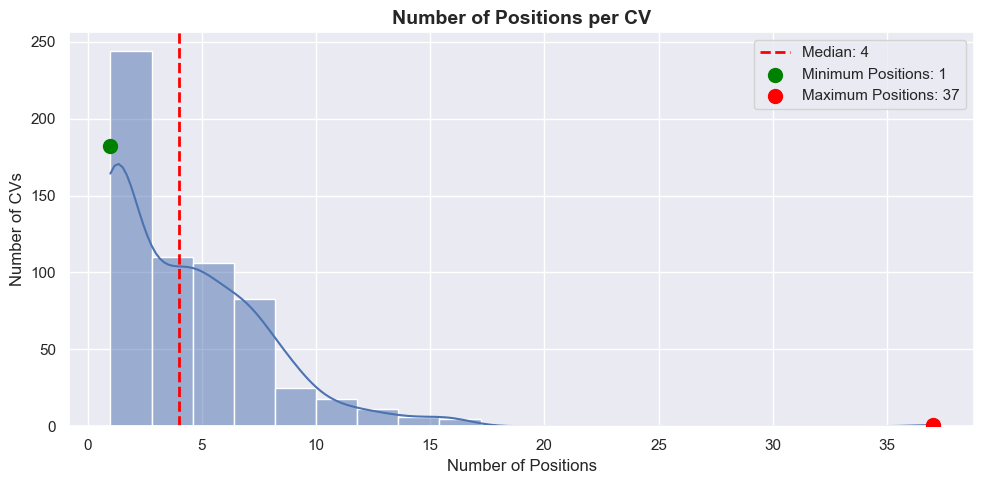

In [63]:
# Positions per CV
positions_per_cv = df_annotated.groupby('cv_id').size()

print("Positions per CV:")
positions_stats = pd.DataFrame({
    'Statistic': ['Count', 'Mean', 'Std', 'Min', '25%', '50% (Median)', '75%', 'Max'],
    'Value': [
        positions_per_cv.count(),
        f"{positions_per_cv.mean():.2f}",
        f"{positions_per_cv.std():.2f}",
        positions_per_cv.min(),
        positions_per_cv.quantile(0.25),
        positions_per_cv.median(),
        positions_per_cv.quantile(0.75),
        positions_per_cv.max()
    ]
})
display(positions_stats)

plt.figure(figsize=(10, 5))
sns.histplot(positions_per_cv, bins=20, kde=True)
plt.title('Number of Positions per CV', fontsize=14, fontweight='bold')
plt.xlabel('Number of Positions')
plt.ylabel('Number of CVs')
plt.axvline(positions_per_cv.median(), color='red', linestyle='--', linewidth=2, label=f"Median: {positions_per_cv.median():.0f}")

# Add scatter points for minimum and maximum
min_positions = positions_per_cv.min()
y_value_min = (positions_per_cv == min_positions).sum()
plt.scatter(min_positions, y_value_min, color='green', s=100, zorder=10, label=f'Minimum Positions: {min_positions}')

max_positions = positions_per_cv.max()
y_value_max = (positions_per_cv == max_positions).sum()
plt.scatter(max_positions, y_value_max, color='red', s=100, zorder=10, label=f'Maximum Positions: {max_positions}')

plt.legend()
plt.tight_layout()
plt.savefig('../reports/figures/positions_per_cv.png', dpi=150)
plt.show()

### Average Position Duration Analysis

In [13]:
# Calculate position duration in months
from datetime import datetime

def parse_date(date_str):
    """Parse date string in format YYYY-MM to datetime."""
    if pd.isna(date_str) or date_str == '':
        return None
    try:
        # Try YYYY-MM format (year and month only)
        return datetime.strptime(date_str, '%Y-%m')
    except:
        try:
            # Fallback: Try YYYY-MM-DD format
            return datetime.strptime(date_str, '%Y-%m-%d')
        except:
            return None

def calculate_duration_months(start_date, end_date):
    """Calculate duration between two dates in months."""
    if start_date is None:
        return None
    if end_date is None:
        # For ACTIVE positions, use current date
        end_date = datetime.now()
    
    # Calculate difference in months
    months = (end_date.year - start_date.year) * 12 + (end_date.month - start_date.month)
    return max(0, months)  # Ensure non-negative

def position_label(idx):
    """Convert position index to ordinal label (1st, 2nd, 3rd, etc.)"""
    suffixes = {1: 'st', 2: 'nd', 3: 'rd'}
    position_num = idx + 1
    if 10 <= position_num % 100 <= 20:
        suffix = 'th'
    else:
        suffix = suffixes.get(position_num % 10, 'th')
    return f"{position_num}{suffix}"

# Parse dates
df_annotated['start_parsed'] = df_annotated['startDate'].apply(parse_date)
df_annotated['end_parsed'] = df_annotated['endDate'].apply(parse_date)

# Calculate duration
df_annotated['duration_months'] = df_annotated.apply(
    lambda row: calculate_duration_months(row['start_parsed'], row['end_parsed']), 
    axis=1
)

# Filter out positions without duration information
df_with_duration = df_annotated[df_annotated['duration_months'].notna()].copy()

print(f"Positions with duration info: {len(df_with_duration)} / {len(df_annotated)}")
print(f"\nDuration statistics (in months):")
print(df_with_duration['duration_months'].describe())

# Calculate average duration by department, seniority, and position sequence
avg_duration_dept = df_with_duration.groupby('department')['duration_months'].mean().sort_values(ascending=False)
avg_duration_sen = df_with_duration.groupby('seniority')['duration_months'].mean().sort_values(ascending=False)

# Calculate average duration by position sequence
avg_duration_by_position_idx = df_with_duration.groupby('position_idx')['duration_months'].agg(['mean', 'count']).reset_index()
avg_duration_by_position_idx.columns = ['position_idx', 'avg_duration', 'count']

# Filter to positions that have at least 10 samples for statistical significance
min_samples = 10
significant_positions = avg_duration_by_position_idx[avg_duration_by_position_idx['count'] >= min_samples].copy()
significant_positions['position_label'] = significant_positions['position_idx'].apply(position_label)

Positions with duration info: 2638 / 2638

Duration statistics (in months):
count    2638.000000
mean       28.312737
std        47.418393
min         0.000000
25%         0.000000
50%        11.000000
75%        36.000000
max       480.000000
Name: duration_months, dtype: float64


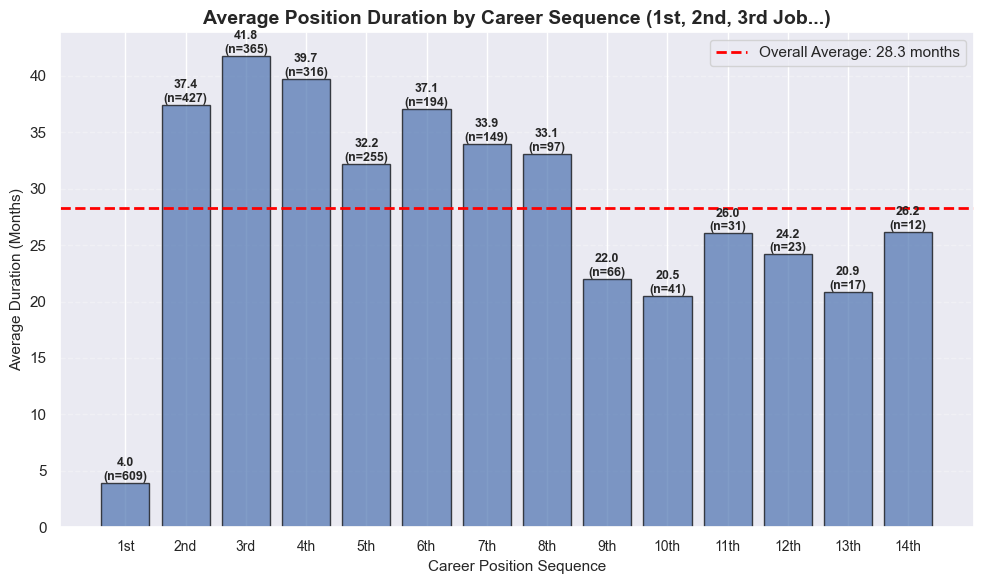

In [14]:
# Plot 3: Average duration by career sequence
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(significant_positions)), significant_positions['avg_duration'], 
                alpha=0.7, edgecolor='black')

# Add value labels on bars
for i, (bar, row) in enumerate(zip(bars, significant_positions.itertuples())):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}\n(n={row.count})',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.axhline(df_with_duration['duration_months'].mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Overall Average: {df_with_duration["duration_months"].mean():.1f} months')
plt.xlabel('Career Position Sequence', fontsize=11)
plt.ylabel('Average Duration (Months)', fontsize=11)
plt.title('Average Position Duration by Career Sequence (1st, 2nd, 3rd Job...)', fontsize=14, fontweight='bold')
plt.xticks(range(len(significant_positions)), significant_positions['position_label'], fontsize=10)
plt.legend()
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig('../reports/figures/avg_duration_by_career_sequence.png', dpi=150, bbox_inches='tight')
plt.show()

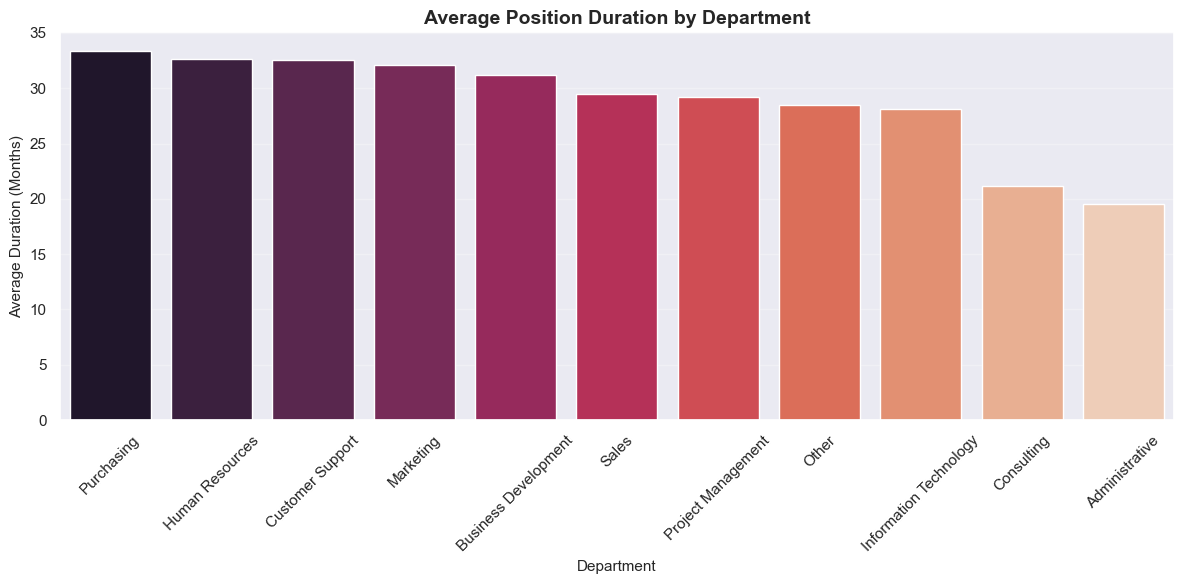

In [66]:
# Plot 1: Average duration by department
plt.figure(figsize=(12, 6))

avg_duration_dept_sorted = avg_duration_dept.sort_values(ascending=False)
sns.barplot(x=avg_duration_dept_sorted.index, y=avg_duration_dept_sorted.values, hue=avg_duration_dept_sorted.index, 
            palette="rocket", legend=False)
plt.title('Average Position Duration by Department', fontsize=14, fontweight='bold')
plt.xlabel('Department', fontsize=11)
plt.ylabel('Average Duration (Months)', fontsize=11)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/avg_duration_dept.png', dpi=150, bbox_inches='tight')
plt.show()

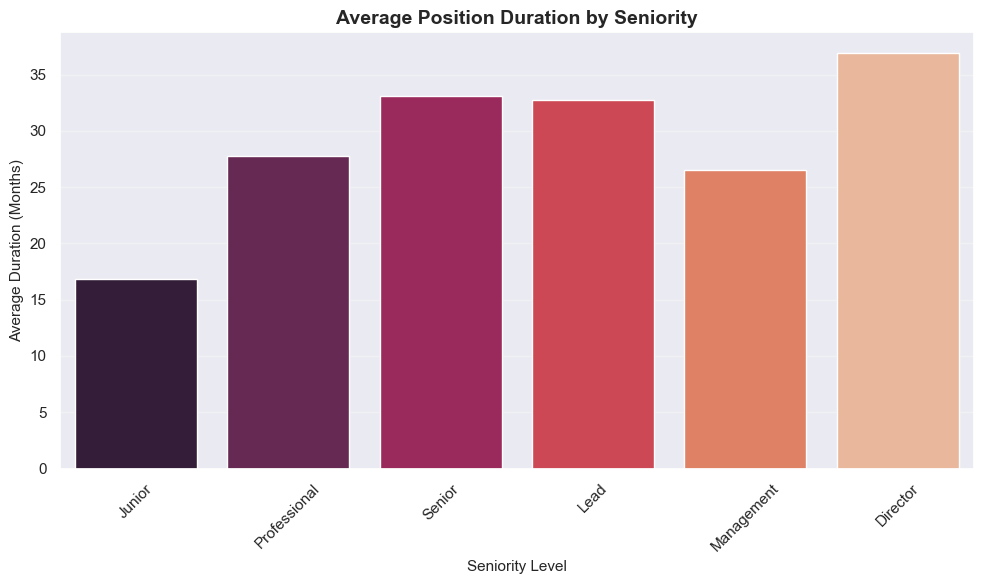

In [65]:
# Plot 2: Average duration by seniority
plt.figure(figsize=(10, 6))

seniority_order = ['Junior', 'Professional', 'Senior', 'Lead', 'Management', 'Director']
avg_duration_sen_sorted = avg_duration_sen.reindex([s for s in seniority_order if s in avg_duration_sen.index])
sns.barplot(x=avg_duration_sen_sorted.index, y=avg_duration_sen_sorted.values, hue=avg_duration_sen_sorted.index, 
            palette="rocket", legend=False)
plt.title('Average Position Duration by Seniority', fontsize=14, fontweight='bold')
plt.xlabel('Seniority Level', fontsize=11)
plt.ylabel('Average Duration (Months)', fontsize=11)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/avg_duration_seniority.png', dpi=150, bbox_inches='tight')
plt.show()

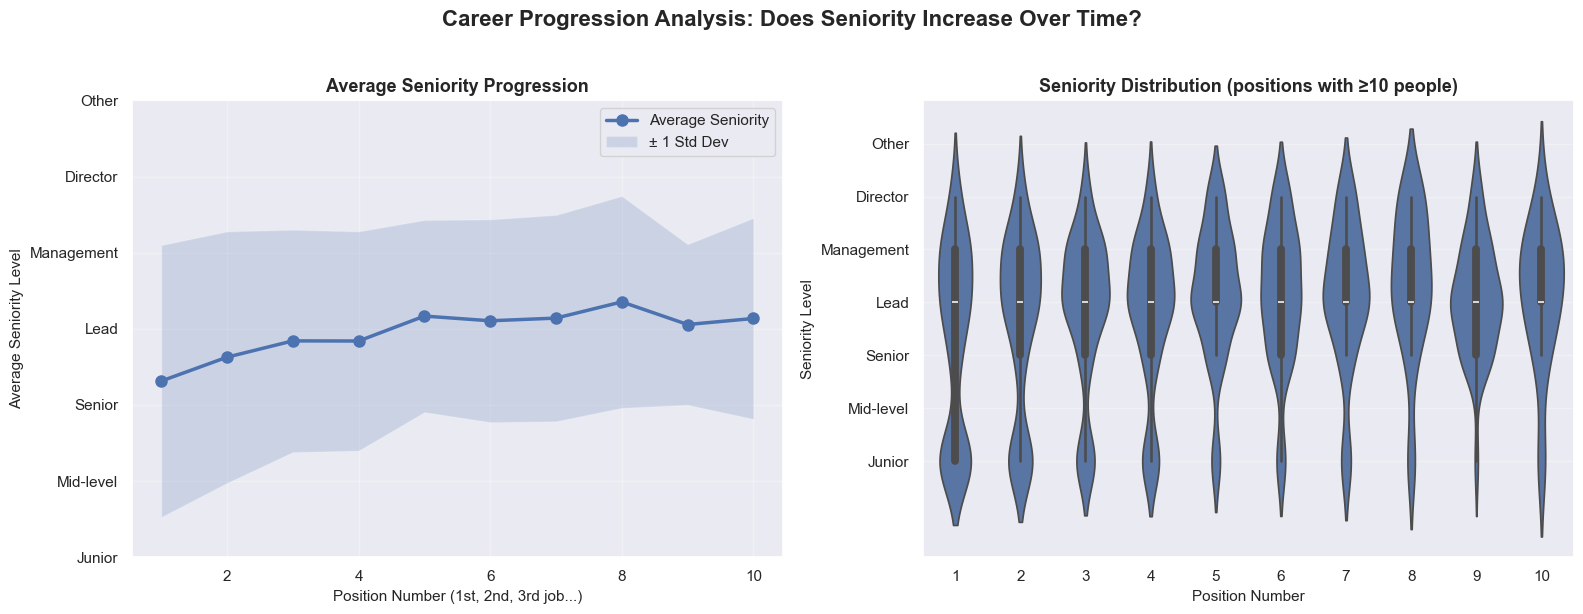


CAREER PROGRESSION SUMMARY

Total people analyzed: 494
Total positions: 2304

Average seniority by position number:
              mean  count
job_sequence             
1             2.31    229
2             2.63    199
3             2.84    190
4             2.84    163
5             3.17    125
6             3.11    113
7             3.14     85
8             3.35     48
9             3.06     35
10            3.14     22

Seniority progression trend: UPWARD ↑


In [16]:
# Analyze seniority progression: Does seniority increase over career progression?
# Prepare data: sort positions by start date for each person
plot_df = df_annotated[df_annotated['startDate'].notna()].copy()

# Convert year-month format to datetime (add day=1 for parsing)
plot_df['startDate'] = pd.to_datetime(plot_df['startDate'] + '-01', errors='coerce')
plot_df = plot_df[plot_df['startDate'].notna()]
plot_df = plot_df.sort_values(['cv_id', 'startDate'])

# Add position sequence number for each CV (1st job, 2nd job, etc.)
plot_df['job_sequence'] = plot_df.groupby('cv_id').cumcount() + 1

# Map seniority to numeric values
seniority_order = ['Junior', 'Mid-level', 'Senior', 'Lead', 'Management', 'Director', 'Other']
seniority_mapping = {level: idx for idx, level in enumerate(seniority_order)}
plot_df['seniority_numeric'] = plot_df['seniority'].map(seniority_mapping)

# Filter to first 10 job positions (most people don't have more)
plot_df_filtered = plot_df[plot_df['job_sequence'] <= 10].copy()

# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Career Progression Analysis: Does Seniority Increase Over Time?', 
             fontsize=16, fontweight='bold', y=1.02)

# Plot 1: Line Plot - Average seniority by job sequence
ax1 = axes[0]
avg_seniority = plot_df_filtered.groupby('job_sequence')['seniority_numeric'].agg(['mean', 'std', 'count'])
ax1.plot(avg_seniority.index, avg_seniority['mean'], marker='o', linewidth=2.5, 
         markersize=8, label='Average Seniority')
ax1.fill_between(avg_seniority.index, 
                  avg_seniority['mean'] - avg_seniority['std'], 
                  avg_seniority['mean'] + avg_seniority['std'], 
                  alpha=0.2, label='± 1 Std Dev')
ax1.set_title('Average Seniority Progression', fontsize=13, fontweight='bold')
ax1.set_xlabel('Position Number (1st, 2nd, 3rd job...)', fontsize=11)
ax1.set_ylabel('Average Seniority Level', fontsize=11)
ax1.set_yticks(range(len(seniority_order)))
ax1.set_yticklabels(seniority_order)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Violin Plot - Seniority distribution by job sequence
ax2 = axes[1]
# Only plot for job sequences with enough data
job_seq_counts = plot_df_filtered['job_sequence'].value_counts().sort_index()
jobs_with_enough_data = job_seq_counts[job_seq_counts >= 10].index.tolist()
plot_df_violin = plot_df_filtered[plot_df_filtered['job_sequence'].isin(jobs_with_enough_data)]
sns.violinplot(data=plot_df_violin, x='job_sequence', y='seniority_numeric', ax=ax2)
ax2.set_title(f'Seniority Distribution (positions with ≥10 people)', fontsize=13, fontweight='bold')
ax2.set_xlabel('Position Number', fontsize=11)
ax2.set_ylabel('Seniority Level', fontsize=11)
ax2.set_yticks(range(len(seniority_order)))
ax2.set_yticklabels(seniority_order)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/seniority_progression_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\n" + "="*80)
print("CAREER PROGRESSION SUMMARY")
print("="*80)
print(f"\nTotal people analyzed: {plot_df['cv_id'].nunique()}")
print(f"Total positions: {len(plot_df)}")
print(f"\nAverage seniority by position number:")
print(avg_seniority[['mean', 'count']].round(2))
print("\nSeniority progression trend:", 
      "UPWARD ↑" if avg_seniority['mean'].iloc[-1] > avg_seniority['mean'].iloc[0] else "FLAT →")
print("="*80)

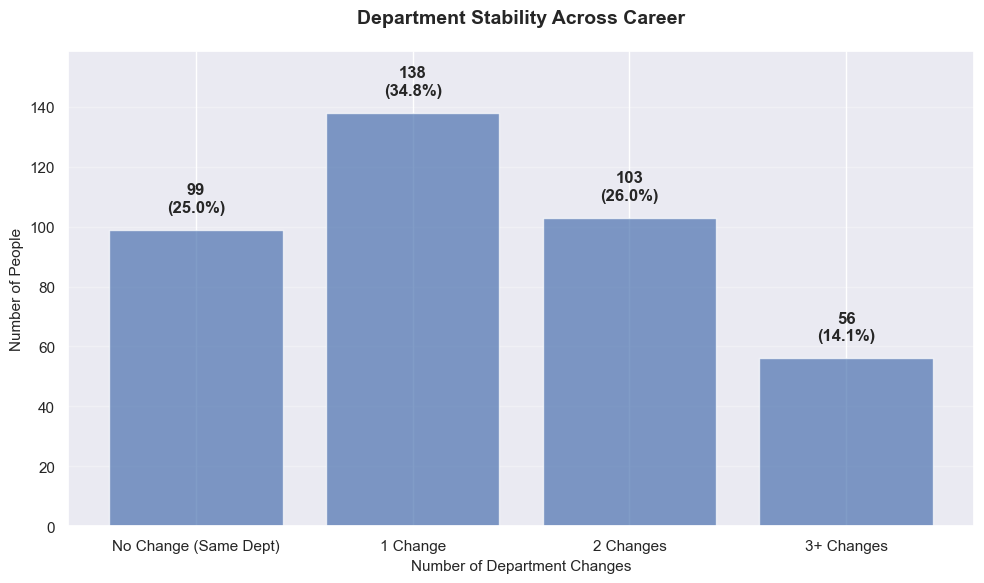

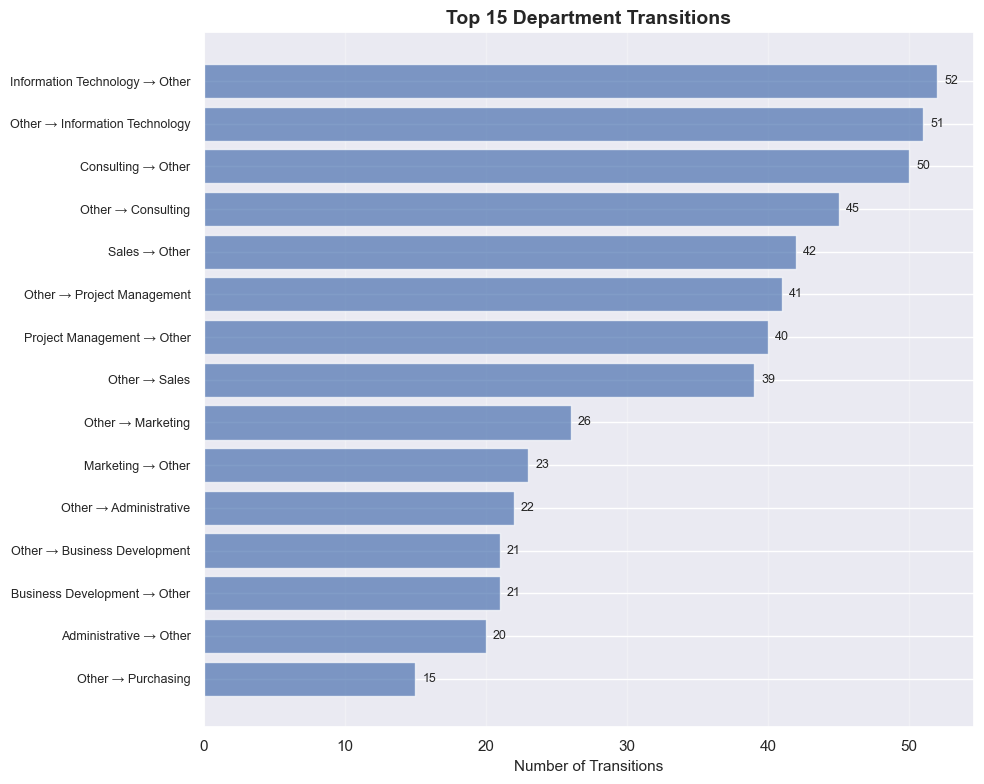


DEPARTMENT CHANGE ANALYSIS

People with multiple jobs: 396
Total department changes: 535
Average department changes per person: 1.35

People who stayed in same department: 99 (25.0%)
People who switched departments: 297 (75.0%)

Most common department transitions:
Information Technology → Other    52
Other → Information Technology    51
Consulting → Other                50
Other → Consulting                45
Sales → Other                     42
Other → Project Management        41
Project Management → Other        40
Other → Sales                     39
Other → Marketing                 26
Marketing → Other                 23
Name: count, dtype: int64


In [17]:
# Analyze department changes: Do people switch departments during their career?
# Use the same prepared data from seniority analysis
dept_df = plot_df.copy()

# Calculate department changes per person
dept_changes = dept_df.groupby('cv_id').agg({
    'department': lambda x: len(set(x)) - 1,  # Number of different departments - 1 = changes
    'job_sequence': 'max'  # Total number of jobs
}).reset_index()
dept_changes.columns = ['cv_id', 'dept_changes', 'total_jobs']

# Only consider people with multiple jobs
dept_changes_filtered = dept_changes[dept_changes['total_jobs'] > 1].copy()

# Categorize people
def categorize_changes(changes):
    if changes == 0:
        return 'No Change (Same Dept)'
    elif changes == 1:
        return '1 Change'
    elif changes == 2:
        return '2 Changes'
    else:
        return '3+ Changes'

dept_changes_filtered['category'] = dept_changes_filtered['dept_changes'].apply(categorize_changes)

# Count by category
change_counts = dept_changes_filtered['category'].value_counts()
change_order = ['No Change (Same Dept)', '1 Change', '2 Changes', '3+ Changes']
change_counts = change_counts.reindex(change_order, fill_value=0)

# Plot 1: Department Stability - How many people stay vs. switch
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(change_counts)), change_counts.values, alpha=0.7)
plt.xticks(range(len(change_counts)), change_counts.index, rotation=0)
plt.title('Department Stability Across Career', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Number of Department Changes', fontsize=11)
plt.ylabel('Number of People', fontsize=11)
plt.grid(axis='y', alpha=0.3)

# Add percentage labels on bars
max_height = max(change_counts.values)
for i, (bar, count) in enumerate(zip(bars, change_counts.values)):
    percentage = (count / change_counts.sum()) * 100
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
             f'{count}\n({percentage:.1f}%)', ha='center', va='bottom', fontweight='bold')

# Adjust y-axis to make room for labels
plt.ylim(0, max_height * 1.15)

plt.tight_layout()
plt.savefig('../reports/figures/department_stability.png', dpi=150, bbox_inches='tight')
plt.show()

# Find all department transitions (from job n to job n+1)
transitions = []
for cv_id in dept_df['cv_id'].unique():
    person_data = dept_df[dept_df['cv_id'] == cv_id].sort_values('startDate')
    if len(person_data) > 1:
        for i in range(len(person_data) - 1):
            from_dept = person_data.iloc[i]['department']
            to_dept = person_data.iloc[i+1]['department']
            if from_dept != to_dept:  # Only count actual changes
                transitions.append(f"{from_dept} → {to_dept}")

# Count transitions
transition_counts = pd.Series(transitions).value_counts().head(15)

# Plot 2: Top Department Transitions
plt.figure(figsize=(10, 8))
plt.barh(range(len(transition_counts)), transition_counts.values, alpha=0.7)
plt.yticks(range(len(transition_counts)), transition_counts.index, fontsize=9)
plt.title('Top 15 Department Transitions', fontsize=14, fontweight='bold')
plt.xlabel('Number of Transitions', fontsize=11)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)

# Add count labels
for i, count in enumerate(transition_counts.values):
    plt.text(count + 0.5, i, str(count), va='center', fontsize=9)

plt.tight_layout()
plt.savefig('../reports/figures/department_transitions.png', dpi=150, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\n" + "="*80)
print("DEPARTMENT CHANGE ANALYSIS")
print("="*80)
print(f"\nPeople with multiple jobs: {len(dept_changes_filtered)}")
print(f"Total department changes: {dept_changes_filtered['dept_changes'].sum()}")
print(f"Average department changes per person: {dept_changes_filtered['dept_changes'].mean():.2f}")
print(f"\nPeople who stayed in same department: {change_counts['No Change (Same Dept)']} ({change_counts['No Change (Same Dept)']/change_counts.sum()*100:.1f}%)")
print(f"People who switched departments: {change_counts.sum() - change_counts['No Change (Same Dept)']} ({(change_counts.sum() - change_counts['No Change (Same Dept)'])/change_counts.sum()*100:.1f}%)")
print("\nMost common department transitions:")
print(transition_counts.head(10))
print("="*80)

## 2.2 Filter to ACTIVE Positions (Our Target)

According to the project description, we need to predict characteristics of the **current job** (status = ACTIVE).

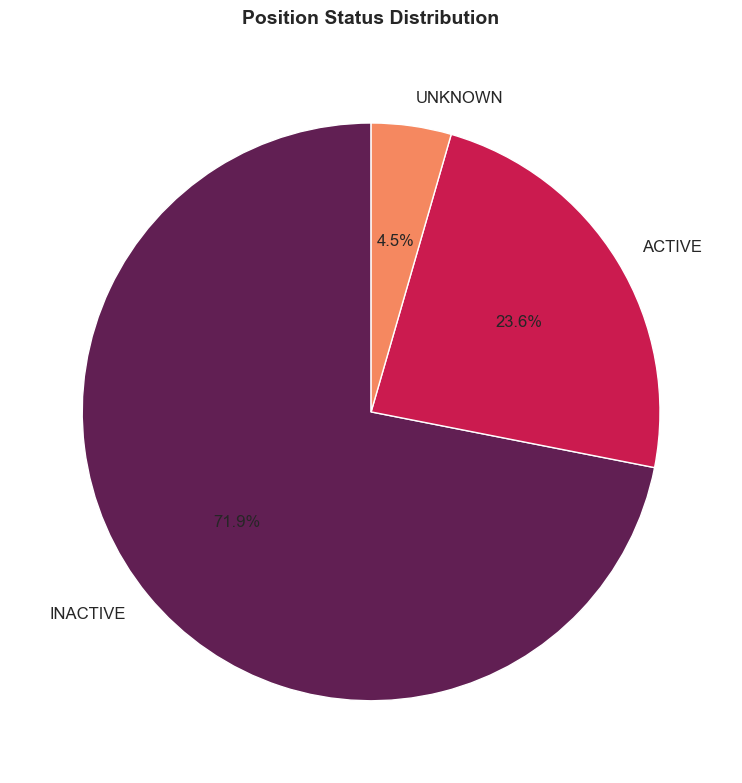

In [18]:
# Visualize status distribution as pie chart
status_counts = df_annotated['status'].value_counts()
colors = sns.color_palette('rocket', n_colors=len(status_counts))

plt.figure(figsize=(8, 8))
plt.pie(status_counts.values, labels=status_counts.index, autopct='%1.1f%%', 
        startangle=90, colors=colors, textprops={'fontsize': 12})
plt.title('Position Status Distribution', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../reports/figures/status_distribution_pie.png', dpi=150)
plt.show()

In [19]:
# Filter to active positions only
df_active = df_annotated[df_annotated['status'] == 'ACTIVE'].copy()
print(f"Active positions: {len(df_active)}")
print(f"Unique CVs with active positions: {df_active['cv_id'].nunique()}")

Active positions: 623
Unique CVs with active positions: 478


In [20]:
# Some people have multiple active positions!
active_per_cv = df_active.groupby('cv_id').size()
active_counts = active_per_cv.value_counts().sort_index()

active_table = pd.DataFrame({
    'Active Positions': active_counts.index,
    'Number of CVs': active_counts.values,
    'Percentage (%)': (active_counts / active_counts.sum() * 100).round(2)
})

print("Active positions per CV:")
display(active_table)

Active positions per CV:


,Active Positions,Number of CVs,Percentage (%)
1,1,380,79.50
2,2,78,16.32
3,3,10,2.09
4,4,3,0.63
5,5,4,0.84
7,7,1,0.21
8,8,1,0.21
10,10,1,0.21


In [21]:
# Check for most common values in active positions
print("Most Common Values in Active Positions:\n")

# Most common organizations
print("=== Top 10 Organizations (Active Positions) ===")
org_counts = df_active['organization'].value_counts().head(10)
org_table = pd.DataFrame({
    'Organization': org_counts.index,
    'Count': org_counts.values,
    'Percentage (%)': (org_counts / len(df_active) * 100).round(2)
})
display(org_table)

# Most common position titles
print("\n=== Top 10 Position Titles (Active Positions) ===")
position_counts = df_active['position'].value_counts().head(10)
position_table = pd.DataFrame({
    'Position Title': position_counts.index,
    'Count': position_counts.values,
    'Percentage (%)': (position_counts / len(df_active) * 100).round(2)
})
display(position_table)

Most Common Values in Active Positions:

=== Top 10 Organizations (Active Positions) ===


,Organization,Count,Percentage (%)
organization,,,
Depot4Design GmbH,Depot4Design GmbH,5,0.80
Selbstständig,Selbstständig,5,0.80
OpenExO,OpenExO,5,0.80
Frankfurt School of Finance & Management,Frankfurt School of Finance & Management,4,0.64
ALIUD PHARMA GmbH,ALIUD PHARMA GmbH,3,0.48
GENUSSMOMENTE für digitales Zusammensein,GENUSSMOMENTE für digitales Zusammensein,3,0.48
KAISERSCHOTE Feinkost Catering GmbH,KAISERSCHOTE Feinkost Catering GmbH,3,0.48
Freelance,Freelance,3,0.48
Stork Lijmen,Stork Lijmen,2,0.32



=== Top 10 Position Titles (Active Positions) ===


,Position Title,Count,Percentage (%)
position,,,
Geschäftsführer,Geschäftsführer,19,3.05
Managing Director,Managing Director,12,1.93
CEO,CEO,11,1.77
Geschäftsführender Gesellschafter,Geschäftsführender Gesellschafter,9,1.44
Owner,Owner,6,0.96
Partner,Partner,6,0.96
Unternehmensinhaber,Unternehmensinhaber,6,0.96
Set Lighting,Set Lighting,5,0.80
Member,Member,5,0.80


## 2.3 Department Analysis

In [22]:
# Department distribution in active positions
dept_counts = df_active['department'].value_counts()
dept_percentages = (dept_counts / dept_counts.sum() * 100).round(1)

dept_table = pd.DataFrame({
    'Department': dept_counts.index,
    'Count': dept_counts.values,
    'Percentage (%)': dept_percentages.values
})

print(f"Unique departments: {len(dept_counts)}\n")
print("Department Distribution:")
display(dept_table)

Unique departments: 11

Department Distribution:


,Department,Count,Percentage (%)
0,Other,344,55.2
1,Information Technology,62,10.0
2,Sales,46,7.4
3,Consulting,39,6.3
4,Project Management,39,6.3
5,Marketing,22,3.5
6,Business Development,20,3.2
7,Human Resources,16,2.6
8,Purchasing,15,2.4
9,Administrative,14,2.2


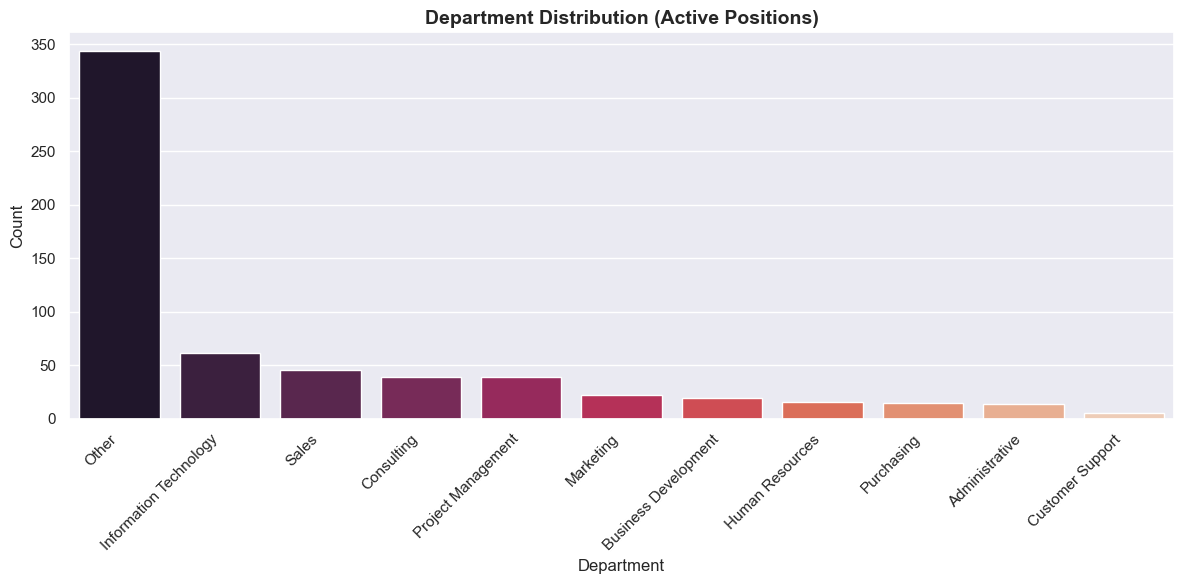

In [23]:
# Visualize department distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=dept_counts.index, y=dept_counts.values, hue=dept_counts.index, palette='rocket', legend=False)
plt.title('Department Distribution (Active Positions)', fontsize=14, fontweight='bold')
plt.xlabel('Department')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('../reports/figures/department_distribution.png', dpi=150)
plt.show()

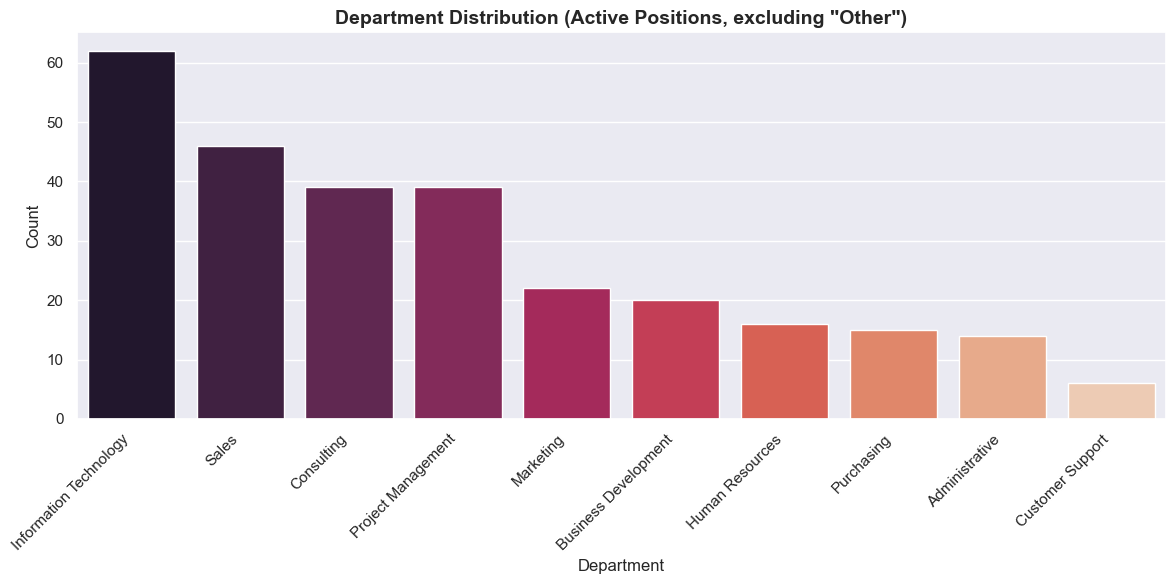

In [24]:
# Visualize department distribution without "Other" category
dept_counts_no_other = dept_counts[dept_counts.index != 'Other']

plt.figure(figsize=(12, 6))
sns.barplot(x=dept_counts_no_other.index, y=dept_counts_no_other.values, hue=dept_counts_no_other.index, palette='rocket', legend=False)
plt.title('Department Distribution (Active Positions, excluding "Other")', fontsize=14, fontweight='bold')
plt.xlabel('Department')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('../reports/figures/department_distribution_no_other.png', dpi=150)
plt.show()

### Department Observations:
- **"Other"** is the most common category - this is a catch-all for unclassified positions
- **Class imbalance** is significant - some departments have very few samples
- **No duplicate descriptions**: All job title descriptions are unique - no title is assigned to multiple departments (same language)

## 2.4 Seniority Analysis

In [26]:
# Seniority distribution
seniority_counts = df_active['seniority'].value_counts()

seniority_dist_table = pd.DataFrame({
    'Seniority Level': seniority_counts.index,
    'Count': seniority_counts.values
})

print(f"Unique seniority levels: {len(seniority_counts)}\n")
print("Seniority Distribution:")
display(seniority_dist_table)

Unique seniority levels: 6

Seniority Distribution:


,Seniority Level,Count
0,Professional,216
1,Management,192
2,Lead,125
3,Senior,44
4,Director,34
5,Junior,12


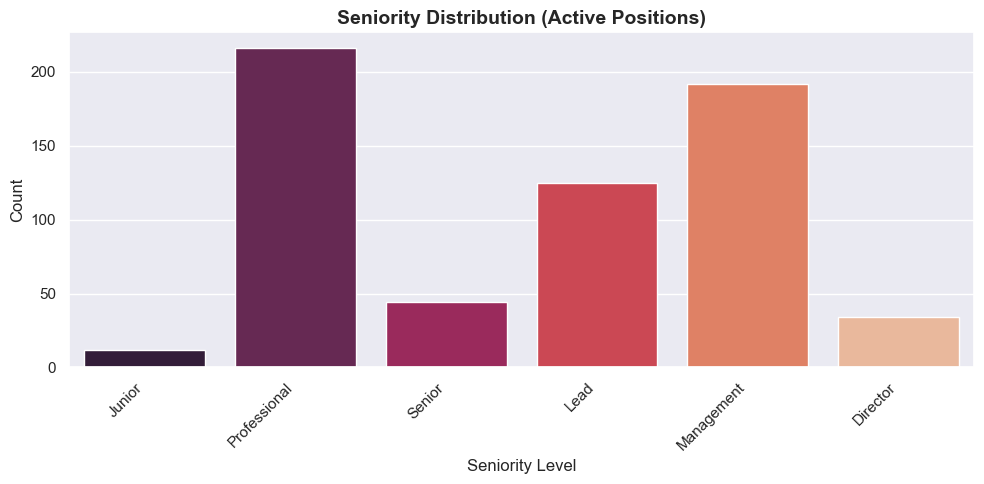

In [27]:
# Visualize seniority distribution
plt.figure(figsize=(10, 5))

# Define custom order
seniority_order = ['Junior', 'Professional', 'Senior', 'Lead', 'Management', 'Director']
# Reindex to match the desired order, keeping only existing categories
seniority_ordered = seniority_counts.reindex([s for s in seniority_order if s in seniority_counts.index])

sns.barplot(x=seniority_ordered.index, y=seniority_ordered.values, hue=seniority_ordered.index, palette='rocket', legend=False)
plt.title('Seniority Distribution (Active Positions)', fontsize=14, fontweight='bold')
plt.xlabel('Seniority Level')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('../reports/figures/seniority_distribution.png', dpi=150)
plt.show()

In [28]:
# Seniority proportions
seniority_props = (seniority_counts / seniority_counts.sum() * 100).round(1)

# Apply the same order as in the visualization
seniority_order = ['Junior', 'Professional', 'Senior', 'Lead', 'Management', 'Director']
seniority_props_ordered = seniority_props.reindex([s for s in seniority_order if s in seniority_props.index])

seniority_table = pd.DataFrame({
    'Seniority Level': seniority_props_ordered.index,
    'Percentage (%)': seniority_props_ordered.values
})

print("Seniority Proportions (%):")
display(seniority_table)

Seniority Proportions (%):


,Seniority Level,Percentage (%)
0,Junior,1.9
1,Professional,34.7
2,Senior,7.1
3,Lead,20.1
4,Management,30.8
5,Director,5.5


### Seniority Observations:
- **Professional** (34.7%) and **Management** (30.8%) dominate the dataset
- **Lead** positions represent 20.1% - well-represented
- **Senior** (7.1%), **Director** (5.5%), and **Junior** (1.9%) are less common
- More balanced distribution than departments
- All seniority levels have at least some representation
- **No duplicate descriptions**: All job title descriptions are unique - no title is assigned to multiple seniority levels (same language)

## 2.5 Position Title Analysis

In [29]:
# Text length analysis
df_active['title_length'] = df_active['position'].str.len()
df_active['title_word_count'] = df_active['position'].str.split().str.len()

print("Position Title Statistics:")
stats_table = df_active[['title_length', 'title_word_count']].describe().T
stats_table = stats_table.round(2)
display(stats_table)

Position Title Statistics:


,count,mean,std,min,25%,50%,75%,max
title_length,623.0,25.03,16.11,3.0,15.0,21.0,33.0,99.0
title_word_count,623.0,3.02,2.22,1.0,1.0,2.0,4.0,15.0


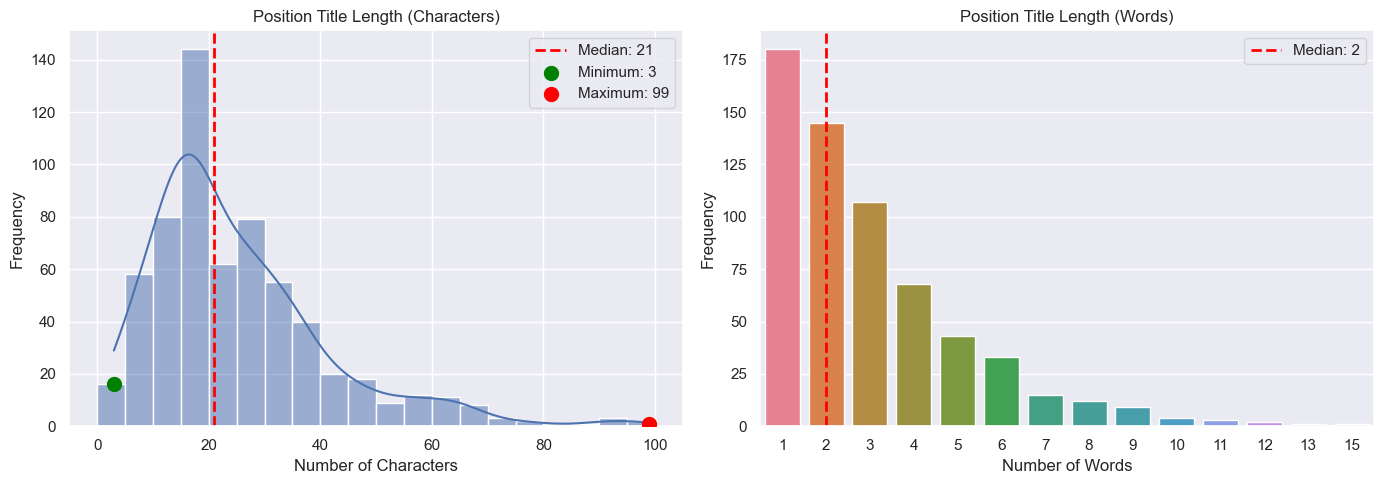

In [30]:
# Visualize title length distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Character length - use bins aligned with integer values
bins = range(0, int(df_active['title_length'].max()) + 5, 5)
sns.histplot(df_active['title_length'], bins=bins, kde=True, ax=axes[0])
axes[0].set_title('Position Title Length (Characters)', fontsize=12)
axes[0].set_xlabel('Number of Characters')
axes[0].set_ylabel('Frequency')
median_chars = df_active['title_length'].median()
axes[0].axvline(median_chars, color='red', linestyle='--', linewidth=2, label=f"Median: {median_chars:.0f}")

# Add scatter points for minimum and maximum
min_length = df_active['title_length'].min()
y_value_min = (df_active['title_length'] == min_length).sum()
axes[0].scatter(min_length, y_value_min, color='green', s=100, zorder=10, label=f'Minimum: {min_length}')

max_length = df_active['title_length'].max()
y_value_max = (df_active['title_length'] == max_length).sum()
axes[0].scatter(max_length, y_value_max, color='red', s=100, zorder=10, label=f'Maximum: {max_length}')

axes[0].legend()

# Word count - use countplot for discrete integer values
word_order = sorted(df_active['title_word_count'].dropna().unique())
sns.countplot(x=df_active['title_word_count'], ax=axes[1], hue=df_active['title_word_count'], palette='husl', order=word_order, legend=False)
axes[1].set_title('Position Title Length (Words)', fontsize=12)
axes[1].set_xlabel('Number of Words')
axes[1].set_ylabel('Frequency')
# For countplot, axvline uses bar index (0, 1, 2...), not the actual x-value
median_words = df_active['title_word_count'].median()
median_idx = word_order.index(median_words) if median_words in word_order else None
if median_idx is not None:
    axes[1].axvline(median_idx, color='red', linestyle='--', linewidth=2, label=f"Median: {median_words:.0f}")
    axes[1].legend()

plt.tight_layout()
plt.savefig('../reports/figures/title_length_distribution.png', dpi=150)
plt.show()

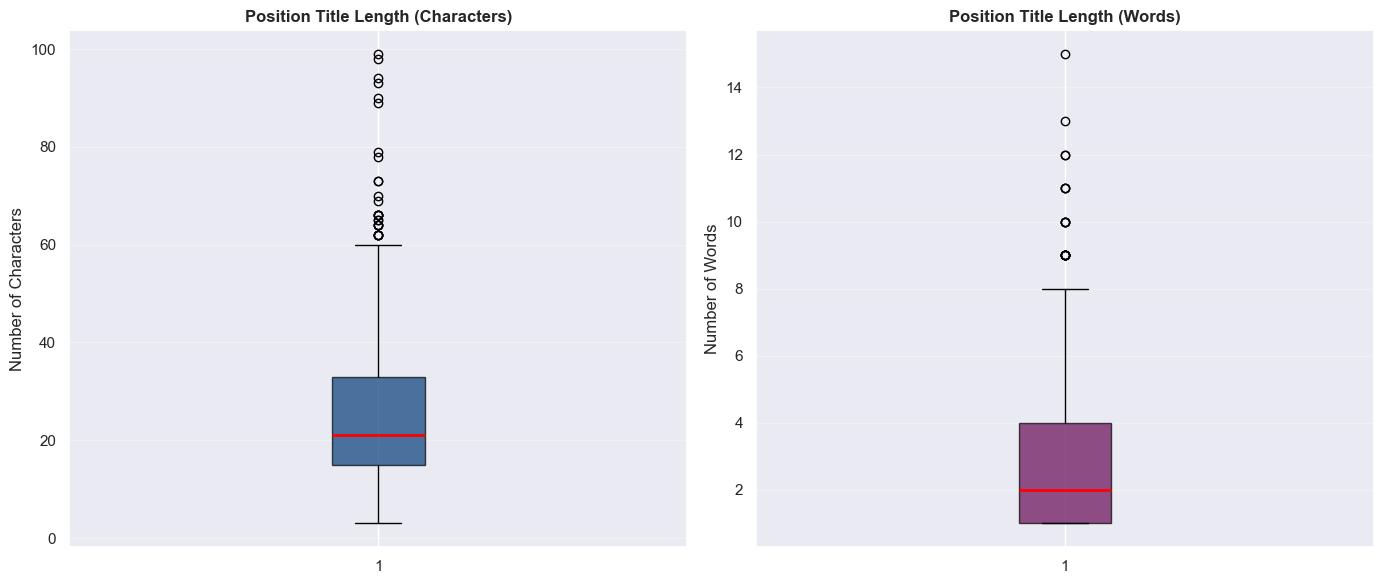

In [31]:
# Boxplots for position title length
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Character length boxplot
bp1 = axes[0].boxplot(df_active['title_length'].dropna(), vert=True, patch_artist=True,
                       boxprops=dict(facecolor='#063D79', alpha=0.7),
                       medianprops=dict(color='red', linewidth=2))
axes[0].set_title('Position Title Length (Characters)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Characters')
axes[0].grid(axis='y', alpha=0.3)

# Word count boxplot
bp2 = axes[1].boxplot(df_active['title_word_count'].dropna(), vert=True, patch_artist=True,
                       boxprops=dict(facecolor='#660954', alpha=0.7),
                       medianprops=dict(color='red', linewidth=2))
axes[1].set_title('Position Title Length (Words)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Number of Words')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/title_length_boxplots.png', dpi=150)
plt.show()

In [32]:
# Top 10 shortest position titles
shortest_titles = df_active.nsmallest(10, 'title_length')[['position', 'title_length', 'department']]
shortest_titles_table = shortest_titles.reset_index(drop=True)
shortest_titles_table.index = shortest_titles_table.index + 1

print("Top 10 Shortest Position Titles:")
display(shortest_titles_table)

Top 10 Shortest Position Titles:


,position,title_length,department
1,CFO,3,Other
2,CFO,3,Other
3,CEO,3,Other
4,CEO,3,Other
5,CTO,3,Information Technology
6,CEO,3,Other
7,CEO,3,Other
8,CEO,3,Other
9,CTO,3,Information Technology
10,CEO,3,Other


In [33]:
# Top 20 longest position titles
longest_titles = df_active.nlargest(20, 'title_length')[['position', 'title_length', 'department']]
longest_titles_table = longest_titles.reset_index(drop=True)
longest_titles_table.index = longest_titles_table.index + 1

print("Top 20 Longest Position Titles:")
display(longest_titles_table)

Top 20 Longest Position Titles:


,position,title_length,department
1,Mediaberater DpS - Fachzeitschrift f. Schädlin...,99,Sales
2,"Dezernat für Wirtschaft, Stadtentwicklung, Lie...",98,Other
3,"Vice President, Human Resources, Health & Secu...",94,Human Resources
4,CEO Morgenpost & TAG 24 | Vertriebsleiter Säch...,93,Other
5,Administrateur suppléant/ Membre des Commissio...,90,Other
6,"Facharzt für Orthopädie und Unfallchirurgie,Ch...",89,Other
7,"Architektin, Fachgebietsleitung Technisches un...",79,Project Management
8,Freelance Marketing Consulting / Client Servic...,78,Consulting
9,Global Director Head of Portfolio and Business...,73,Business Development
10,OÖ Koordinator für das Team der Bereiche Besch...,73,Purchasing


In [69]:
# Sample position titles by department
sample_data = []
for dept in df_annotated['department'].unique()[:8]:  # First 8 departments
    samples = df_annotated[df_annotated['department'] == dept]['position'].head(5).tolist()
    for sample in samples:
        sample_data.append({
            'Department': dept,
            'Position Title': sample
        })

sample_table = pd.DataFrame(sample_data)
print("Sample Position Titles by Department:")
display(sample_table)

Sample Position Titles by Department:


,Department,Position Title
0,Other,Prokurist
1,Other,CFO
2,Other,Betriebswirtin
3,Other,Prokuristin
4,Other,CFO
5,Information Technology,Solutions Architect
6,Information Technology,Senior Network Engineer
7,Information Technology,Manager of Network Services
8,Information Technology,Infrastructure Administrator II
9,Information Technology,Lead Network Engineer


## 2.6 Language Detection (Multilingual Data)

In [71]:
# Simple language detection based on common words
def detect_language_simple(text):
    """Simple heuristic-based language detection."""
    text_lower = text.lower()
    
    # English indicators
    english_words = ['manager', 'senior', 'lead', 'engineer', 'developer', 'analyst', 'consultant', 'specialist', 
                    'coordinator', 'director', 'assistant', 'executive', 'officer', 'supervisor', 'administrator', 
                    'technician', 'designer', 'architect', 'sales', 'marketing', 'project', 'business']
    # German indicators
    german_words = ['und', 'der', 'die', 'für', 'bei', 'leiter', 'berater', 'mitarbeiter', 'geschäftsführer', 'vertrieb',
                    'kaufmann', 'ingenieur', 'entwickler', 'sachbearbeiter', 'direktor', 'koordinator', 'stellvertreter',
                    'abteilungsleiter', 'projektleiter', 'fachkraft', 'assistent', 'referent', 'teamleiter', 'verwaltungsangestellter', 'bauverwaltung']
    # French indicators
    french_words = ['de', 'du', 'la', 'le', 'responsable', 'directeur', 'chargé', 'chef',
                    'ingénieur', 'coordinateur', 'adjoint', 'technicien', 'gestionnaire', 'administrateur',
                    'superviseur', 'cadre', 'attaché', 'contrôleur', 'conseiller', 'analyste']
    # Spanish indicators
    spanish_words = ['de', 'del', 'director', 'gerente', 'jefe',
                    'coordinador', 'ingeniero', 'técnico', 'administrador', 'ejecutivo', 'asistente',
                    'supervisor', 'encargado', 'responsable', 'especialista', 'analista', 'consultor']
    # Turkish indicators
    turkish_words = ['ve', 'müdür', 'uzman', 'sorumlu', 'başkan', 'yönetici', 'danışman', 'müdürü',
                    'koordinatör', 'mühendis', 'teknisyen', 'asistan', 'yardımcısı', 'genel', 'bölüm',
                    'şef', 'direktör', 'proje', 'uzmanı', 'başkanı']
    
    english_score = sum(1 for w in english_words if w in text_lower)
    german_score = sum(1 for w in german_words if w in text_lower)
    french_score = sum(1 for w in french_words if w in text_lower)
    spanish_score = sum(1 for w in spanish_words if w in text_lower)
    turkish_score = sum(1 for w in turkish_words if w in text_lower)
    
    # Return language with highest score
    max_score = max(english_score, german_score, french_score, spanish_score, turkish_score)
    if max_score == 0:
        return 'Other'
    elif english_score == max_score:
        return 'English'
    elif german_score == max_score:
        return 'German'
    elif french_score == max_score:
        return 'French'
    elif spanish_score == max_score:
        return 'Spanish'
    else:
        return 'Turkish'

df_annotated['detected_language'] = df_annotated['position'].apply(detect_language_simple)

# Create language distribution table
lang_counts = df_annotated['detected_language'].value_counts()
lang_table = pd.DataFrame({
    'Language': lang_counts.index,
    'Count': lang_counts.values,
    'Percentage (%)': (lang_counts / lang_counts.sum() * 100).round(2)
})

print("Detected Languages:")
display(lang_table)

Detected Languages:


,Language,Count,Percentage (%)
detected_language,,,
English,English,1150,43.59
Other,Other,600,22.74
German,German,434,16.45
French,French,387,14.67
Turkish,Turkish,43,1.63
Spanish,Spanish,24,0.91


In [36]:
# Sample titles by detected language
sample_lang_data = []
for lang in df_active['detected_language'].unique():
    samples = df_active[df_active['detected_language'] == lang]['position'].sample(min(5, len(df_active[df_active['detected_language'] == lang]))).tolist()
    for sample in samples:
        sample_lang_data.append({
            'Language': lang,
            'Position Title': sample
        })

sample_lang_table = pd.DataFrame(sample_lang_data)
print("Sample Position Titles by Language:")
display(sample_lang_table)

Sample Position Titles by Language:


,Language,Position Title
0,Other,Summer Camp Counselor
1,Other,Ambassador
2,Other,Owner
3,Other,VP Purchasing & Supplier Quality Webasto China
4,Other,Set Lighting
5,English,Director of Sales & SDR Germany
6,English,Chief Executive Officer
7,English,Operation Supervisor
8,English,Director
9,English,Business Consultant


### Language Observations:
- The dataset is **multilingual** (English, German, French, Spanish, etc.)
- This is important for model design:
  - Rule-based matching needs multilingual patterns
  - Embeddings should use multilingual models

## 3. Department Label Dictionary Analysis

In [37]:
# Analyze department label dictionary
print("Department Label Dictionary Overview:")
overview_dept = pd.DataFrame({
    'Metric': ['Total examples', 'Unique labels'],
    'Value': [len(department_labels), department_labels['label'].nunique()]
})
display(overview_dept)

print("\nDepartment Labels Distribution:")
dept_label_counts = department_labels['label'].value_counts().reset_index()
dept_label_counts.columns = ['Department', 'Count']
dept_label_counts['Percentage (%)'] = (dept_label_counts['Count'] / dept_label_counts['Count'].sum() * 100).round(2)
display(dept_label_counts)

Department Label Dictionary Overview:


,Metric,Value
0,Total examples,10145
1,Unique labels,11



Department Labels Distribution:


,Department,Count,Percentage (%)
0,Marketing,4295,42.34
1,Sales,3328,32.80
2,Information Technology,1305,12.86
3,Business Development,620,6.11
4,Project Management,201,1.98
5,Consulting,167,1.65
6,Administrative,83,0.82
7,Other,42,0.41
8,Purchasing,40,0.39
9,Customer Support,33,0.33


In [38]:
# Sample text -> label mappings
print("Sample Department Mappings:")
department_labels.sample(10)

Sample Department Mappings:


,text,label
853,CRM Process,Information Technology
5452,Projektleiter - Marketing und Vertrieb,Marketing
6636,Leitung strategisches Marketing,Marketing
524,Digital Data Analyst,Information Technology
5035,Head of International & Digital Sales,Sales
7130,Leitung Vertrieb und Projektmanagement,Sales
5653,Teamleiter Inside Sales,Sales
2473,Team Leader Marketing & Communications,Marketing
9287,Country Sales Manager New Business & Rental Se...,Sales
1341,Fachkonzeptionist Marketing & Kommunikation,Marketing


Department Label Text Statistics:


,count,mean,std,min,25%,50%,75%,max
text_length,10145.0,33.78,13.11,2.0,25.0,32.0,41.0,194.0
text_word_count,10145.0,4.26,1.95,1.0,3.0,4.0,5.0,28.0


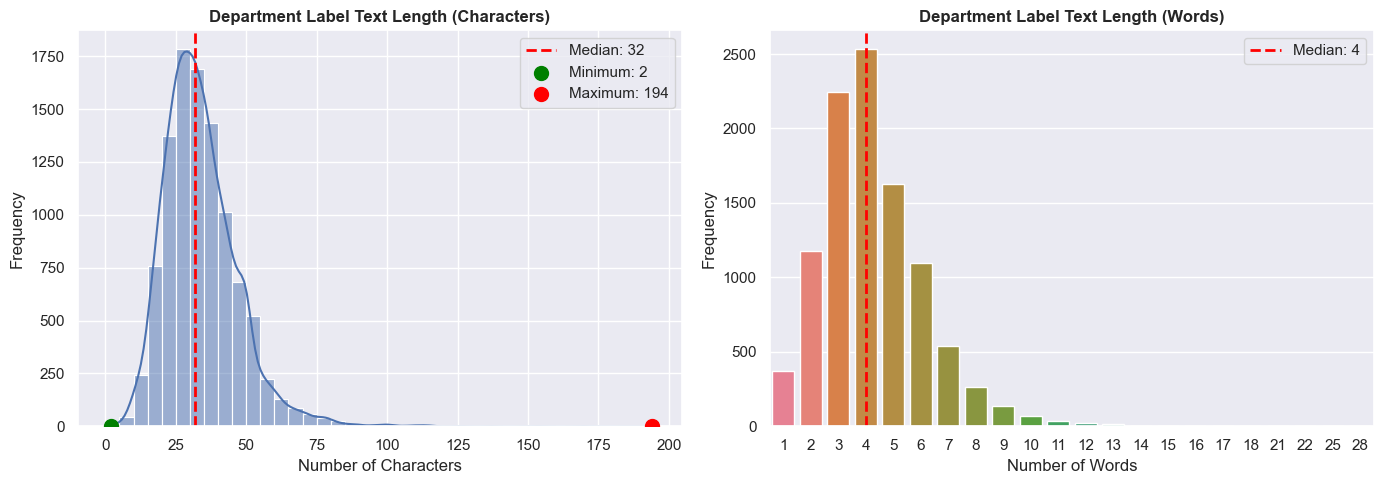

In [39]:
# Analyze text length in department label dictionary
department_labels['text_length'] = department_labels['text'].str.len()
department_labels['text_word_count'] = department_labels['text'].str.split().str.len()

print("Department Label Text Statistics:")
dept_stats_table = department_labels[['text_length', 'text_word_count']].describe().T
dept_stats_table = dept_stats_table.round(2)
display(dept_stats_table)

# Visualize text length distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Character length
bins = range(0, int(department_labels['text_length'].max()) + 5, 5)
sns.histplot(department_labels['text_length'], bins=bins, kde=True, ax=axes[0])
axes[0].set_title('Department Label Text Length (Characters)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Number of Characters')
axes[0].set_ylabel('Frequency')
median_chars = department_labels['text_length'].median()
axes[0].axvline(median_chars, color='red', linestyle='--', linewidth=2, label=f"Median: {median_chars:.0f}")

# Add scatter points for minimum and maximum
hist_counts, bin_edges = np.histogram(department_labels['text_length'], bins=bins)
min_length_dept = department_labels['text_length'].min()
min_bin_idx = np.digitize([min_length_dept], bin_edges)[0] - 1
y_value_min_dept = hist_counts[min_bin_idx]
axes[0].scatter(min_length_dept, y_value_min_dept, color='green', s=100, zorder=10, label=f'Minimum: {min_length_dept}')

max_length_dept = department_labels['text_length'].max()
max_bin_idx = np.digitize([max_length_dept], bin_edges)[0] - 1
y_value_max_dept = hist_counts[max_bin_idx]
axes[0].scatter(max_length_dept, y_value_max_dept, color='red', s=100, zorder=10, label=f'Maximum: {max_length_dept}')

axes[0].legend()

# Word count
word_order = sorted(department_labels['text_word_count'].dropna().unique())
sns.countplot(x=department_labels['text_word_count'], ax=axes[1], hue=department_labels['text_word_count'], palette='husl', order=word_order, legend=False)
axes[1].set_title('Department Label Text Length (Words)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Number of Words')
axes[1].set_ylabel('Frequency')
median_words = department_labels['text_word_count'].median()
median_idx = word_order.index(median_words) if median_words in word_order else None
if median_idx is not None:
    axes[1].axvline(median_idx, color='red', linestyle='--', linewidth=2, label=f"Median: {median_words:.0f}")
    axes[1].legend()

plt.tight_layout()
plt.savefig('../reports/figures/department_label_text_length.png', dpi=150)
plt.show()

## 4. Seniority Label Dictionary Analysis

In [40]:
# Analyze seniority label dictionary
print("Seniority Label Dictionary Overview:")
overview_seniority = pd.DataFrame({
    'Metric': ['Total examples', 'Unique labels'],
    'Value': [len(seniority_labels), seniority_labels['label'].nunique()]
})
display(overview_seniority)

print("\nSeniority Labels Distribution:")
seniority_label_counts = seniority_labels['label'].value_counts()
# Apply the same order
seniority_order = ['Junior', 'Professional', 'Senior', 'Lead', 'Management', 'Director']
seniority_label_counts = seniority_label_counts.reindex([s for s in seniority_order if s in seniority_label_counts.index])
seniority_label_counts_df = seniority_label_counts.reset_index()
seniority_label_counts_df.columns = ['Seniority Level', 'Count']
seniority_label_counts_df['Percentage (%)'] = (seniority_label_counts_df['Count'] / seniority_label_counts_df['Count'].sum() * 100).round(2)
display(seniority_label_counts_df)

Seniority Label Dictionary Overview:


,Metric,Value
0,Total examples,9428
1,Unique labels,5



Seniority Labels Distribution:


,Seniority Level,Count,Percentage (%)
0,Junior,409,4.34
1,Senior,3733,39.59
2,Lead,3546,37.61
3,Management,756,8.02
4,Director,984,10.44


In [41]:
# Check if seniority descriptions are unique
total_sen = len(seniority_labels)
unique_sen = seniority_labels['text'].nunique()
duplicates_sen = total_sen - unique_sen

uniqueness_table_sen = pd.DataFrame({
    'Metric': ['Total seniority entries', 'Unique descriptions', 'Duplicate descriptions', 'Uniqueness rate (%)'],
    'Value': [
        f"{total_sen:,}",
        f"{unique_sen:,}",
        f"{duplicates_sen:,}",
        f"{100 * unique_sen / total_sen:.2f}"
    ]
})

print("Seniority Label Uniqueness Check:")
display(uniqueness_table_sen)

Seniority Label Uniqueness Check:


,Metric,Value
0,Total seniority entries,"9,428"
1,Unique descriptions,"9,428"
2,Duplicate descriptions,0
3,Uniqueness rate (%),100.00


In [42]:
print("Sample Seniority Mappings:")
seniority_labels.sample(10)

Sample Seniority Mappings:


,text,label
4890,Leiter Online-Marketing | Projektmanagement & SEO,Lead
5157,Leitung Unternehmenskommunikation/ Marketing,Lead
8750,Manager Sales Administration,Senior
3433,Verkaufsleiter Döner Handwerk/Industrie,Lead
5076,Leitung Marketing & Verkauf,Lead
4240,Leiter Technikum und technischer Qualfizierung...,Lead
2948,Head of Business and Sales,Lead
8415,Trade Marketing Manager,Senior
7668,Int. Product Managerin & Marketing Managerin,Senior
6137,Head of Sales / Member of the Management Team,Senior


Seniority Label Text Statistics:


,count,mean,std,min,25%,50%,75%,max
text_length,9428.0,33.83,12.93,2.0,25.0,32.0,41.0,153.0
text_word_count,9428.0,4.32,1.92,1.0,3.0,4.0,5.0,25.0


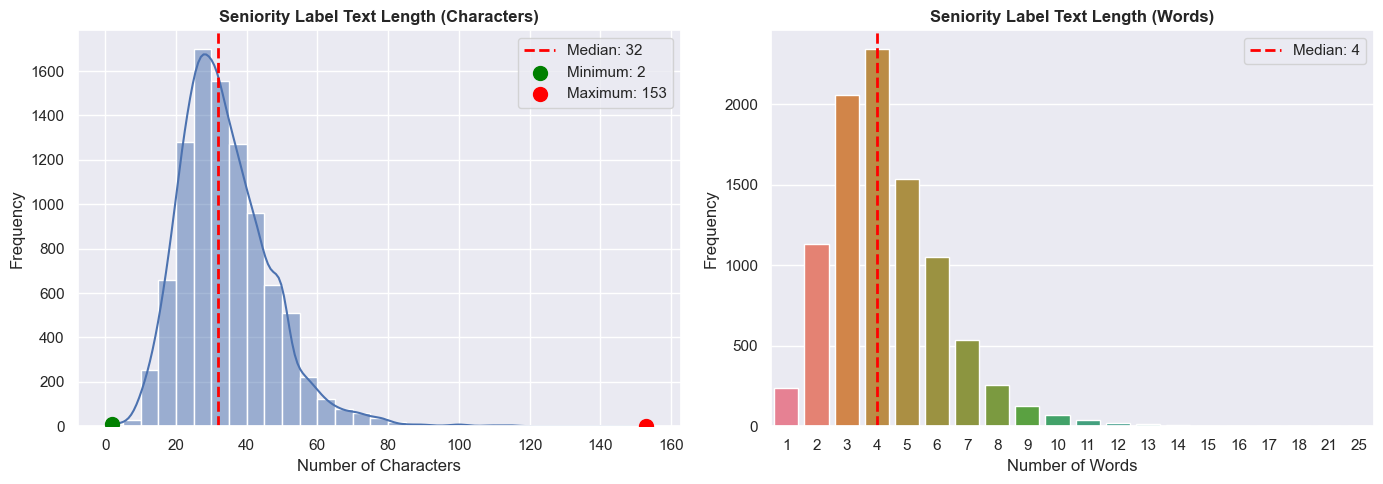

In [43]:
# Analyze text length in seniority label dictionary
seniority_labels['text_length'] = seniority_labels['text'].str.len()
seniority_labels['text_word_count'] = seniority_labels['text'].str.split().str.len()

print("Seniority Label Text Statistics:")
sen_stats_table = seniority_labels[['text_length', 'text_word_count']].describe().T
sen_stats_table = sen_stats_table.round(2)
display(sen_stats_table)

# Visualize text length distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Character length
bins = range(0, int(seniority_labels['text_length'].max()) + 5, 5)
sns.histplot(seniority_labels['text_length'], bins=bins, kde=True, ax=axes[0])
axes[0].set_title('Seniority Label Text Length (Characters)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Number of Characters')
axes[0].set_ylabel('Frequency')
median_chars = seniority_labels['text_length'].median()
axes[0].axvline(median_chars, color='red', linestyle='--', linewidth=2, label=f"Median: {median_chars:.0f}")

# Add scatter points for minimum and maximum
hist_counts, bin_edges = np.histogram(seniority_labels['text_length'], bins=bins)
min_length_sen = seniority_labels['text_length'].min()
min_bin_idx = np.digitize([min_length_sen], bin_edges)[0] - 1
y_value_min_sen = hist_counts[min_bin_idx]
axes[0].scatter(min_length_sen, y_value_min_sen, color='green', s=100, zorder=10, label=f'Minimum: {min_length_sen}')

max_length_sen = seniority_labels['text_length'].max()
max_bin_idx = np.digitize([max_length_sen], bin_edges)[0] - 1
y_value_max_sen = hist_counts[max_bin_idx]
axes[0].scatter(max_length_sen, y_value_max_sen, color='red', s=100, zorder=10, label=f'Maximum: {max_length_sen}')

axes[0].legend()

# Word count
word_order = sorted(seniority_labels['text_word_count'].dropna().unique())
sns.countplot(x=seniority_labels['text_word_count'], ax=axes[1], hue=seniority_labels['text_word_count'], palette='husl', order=word_order, legend=False)
axes[1].set_title('Seniority Label Text Length (Words)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Number of Words')
axes[1].set_ylabel('Frequency')
median_words = seniority_labels['text_word_count'].median()
median_idx = word_order.index(median_words) if median_words in word_order else None
if median_idx is not None:
    axes[1].axvline(median_idx, color='red', linestyle='--', linewidth=2, label=f"Median: {median_words:.0f}")
    axes[1].legend()

plt.tight_layout()
plt.savefig('../reports/figures/seniority_label_text_length.png', dpi=150)
plt.show()

## 5. Non-Annotated CVs Analysis

Let's analyze the non-annotated CVs that we'll use for inference:

In [44]:
# Flatten non-annotated CVs
df_not_annotated = flatten_cvs(cvs_not_annotated, cv_id_start=len(cvs_annotated))

print("\nBasic Statistics:")
stats_df = pd.DataFrame({
    'Metric': ['Total CVs', 'Total Positions', 'Avg Positions per CV'],
    'Value': [
        df_not_annotated['cv_id'].nunique(),
        len(df_not_annotated),
        f"{df_not_annotated.groupby('cv_id').size().mean():.2f}"
    ]
})
display(stats_df)


Basic Statistics:


,Metric,Value
0,Total CVs,390
1,Total Positions,1886
2,Avg Positions per CV,4.84


In [45]:
# Status distribution
print("Status Distribution:")
status_dist = df_not_annotated['status'].value_counts()
status_table = pd.DataFrame({
    'Status': status_dist.index,
    'Count': status_dist.values,
    'Percentage (%)': (status_dist / status_dist.sum() * 100).round(2)
})
display(status_table)

Status Distribution:


,Status,Count,Percentage (%)
status,,,
INACTIVE,INACTIVE,1409,74.71
ACTIVE,ACTIVE,419,22.22
UNKNOWN,UNKNOWN,58,3.08


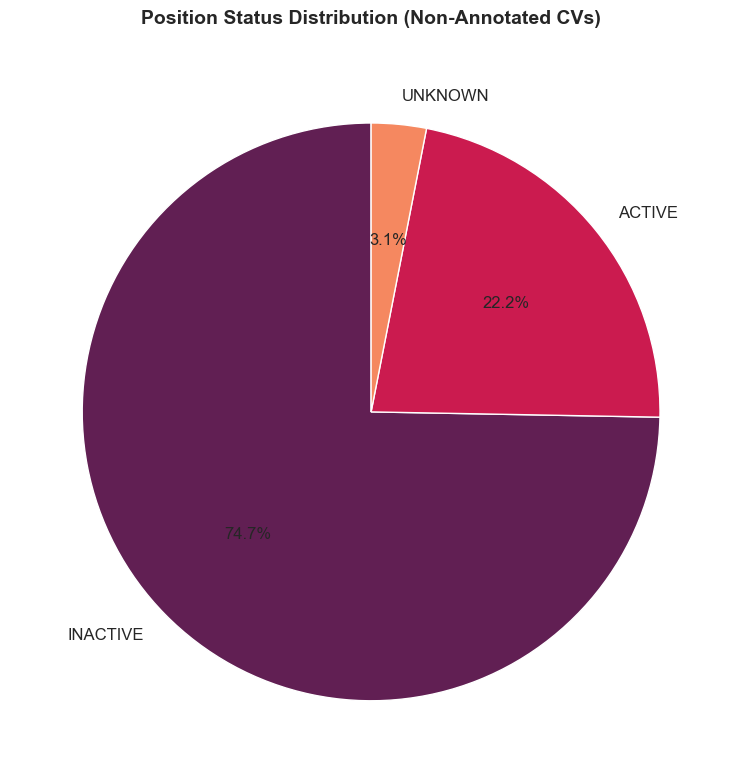

In [46]:
# Visualize status distribution
plt.figure(figsize=(8, 8))
colors = sns.color_palette('rocket', n_colors=len(status_dist))
plt.pie(status_dist.values, labels=status_dist.index, autopct='%1.1f%%', 
        startangle=90, colors=colors, textprops={'fontsize': 12})
plt.title('Position Status Distribution (Non-Annotated CVs)', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../reports/figures/status_distribution_not_annotated_pie.png', dpi=150)
plt.show()

In [47]:
# Positions per CV
positions_per_cv_not_ann = df_not_annotated.groupby('cv_id').size()

print("Positions per CV (Non-Annotated):")
positions_stats_not_ann = pd.DataFrame({
    'Statistic': ['Count', 'Mean', 'Std', 'Min', '25%', '50% (Median)', '75%', 'Max'],
    'Value': [
        positions_per_cv_not_ann.count(),
        f"{positions_per_cv_not_ann.mean():.2f}",
        f"{positions_per_cv_not_ann.std():.2f}",
        positions_per_cv_not_ann.min(),
        positions_per_cv_not_ann.quantile(0.25),
        positions_per_cv_not_ann.median(),
        positions_per_cv_not_ann.quantile(0.75),
        positions_per_cv_not_ann.max()
    ]
})
display(positions_stats_not_ann)

Positions per CV (Non-Annotated):


,Statistic,Value
0,Count,390
1,Mean,4.84
2,Std,3.69
3,Min,1
4,25%,2.0
5,50% (Median),4.0
6,75%,7.0
7,Max,20


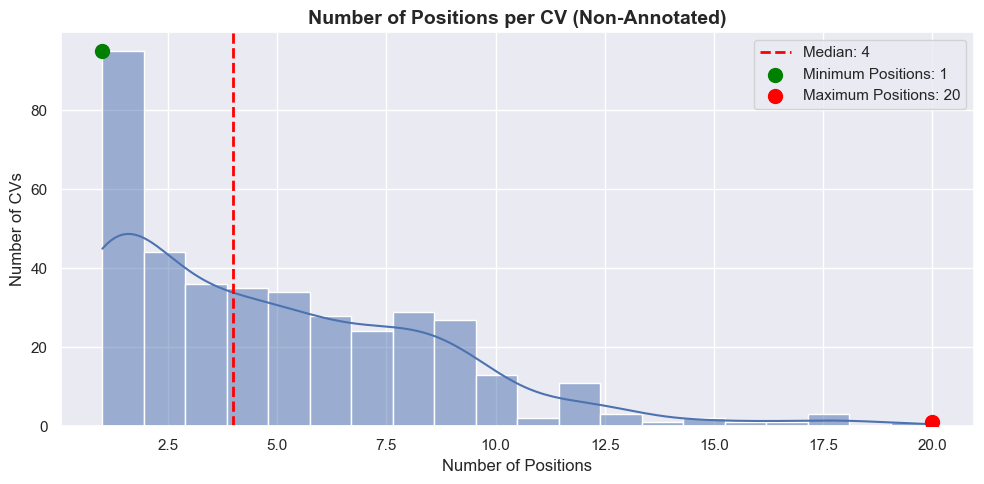

In [48]:
plt.figure(figsize=(10, 5))
sns.histplot(positions_per_cv_not_ann, bins=20, kde=True)
plt.title('Number of Positions per CV (Non-Annotated)', fontsize=14, fontweight='bold')
plt.xlabel('Number of Positions')
plt.ylabel('Number of CVs')
plt.axvline(positions_per_cv_not_ann.median(), color='red', linestyle='--', linewidth=2, 
            label=f"Median: {positions_per_cv_not_ann.median():.0f}")

# Add scatter points for minimum and maximum
hist_counts, bin_edges = np.histogram(positions_per_cv_not_ann, bins=20)
min_positions_not_ann = positions_per_cv_not_ann.min()
min_bin_idx = np.clip(np.digitize([min_positions_not_ann], bin_edges)[0] - 1, 0, len(hist_counts) - 1)
y_value_min_not_ann = hist_counts[min_bin_idx]
plt.scatter(min_positions_not_ann, y_value_min_not_ann, color='green', s=100, zorder=10, label=f'Minimum Positions: {min_positions_not_ann}')

max_positions_not_ann = positions_per_cv_not_ann.max()
max_bin_idx = np.clip(np.digitize([max_positions_not_ann], bin_edges)[0] - 1, 0, len(hist_counts) - 1)
y_value_max_not_ann = hist_counts[max_bin_idx]
plt.scatter(max_positions_not_ann, y_value_max_not_ann, color='red', s=100, zorder=10, label=f'Maximum Positions: {max_positions_not_ann}')

plt.legend()
plt.tight_layout()
plt.savefig('../reports/figures/positions_per_cv_not_annotated.png', dpi=150)
plt.show()

In [49]:
# Position title length analysis
df_not_annotated['title_length'] = df_not_annotated['position'].str.len()
df_not_annotated['title_word_count'] = df_not_annotated['position'].str.split().str.len()

print("Position Title Statistics (Non-Annotated):")
stats_table_not_ann = df_not_annotated[['title_length', 'title_word_count']].describe().T
stats_table_not_ann = stats_table_not_ann.round(2)
display(stats_table_not_ann)

Position Title Statistics (Non-Annotated):


,count,mean,std,min,25%,50%,75%,max
title_length,1886.0,25.18,14.76,2.0,15.0,21.0,32.0,97.0
title_word_count,1886.0,3.06,2.01,1.0,2.0,3.0,4.0,14.0


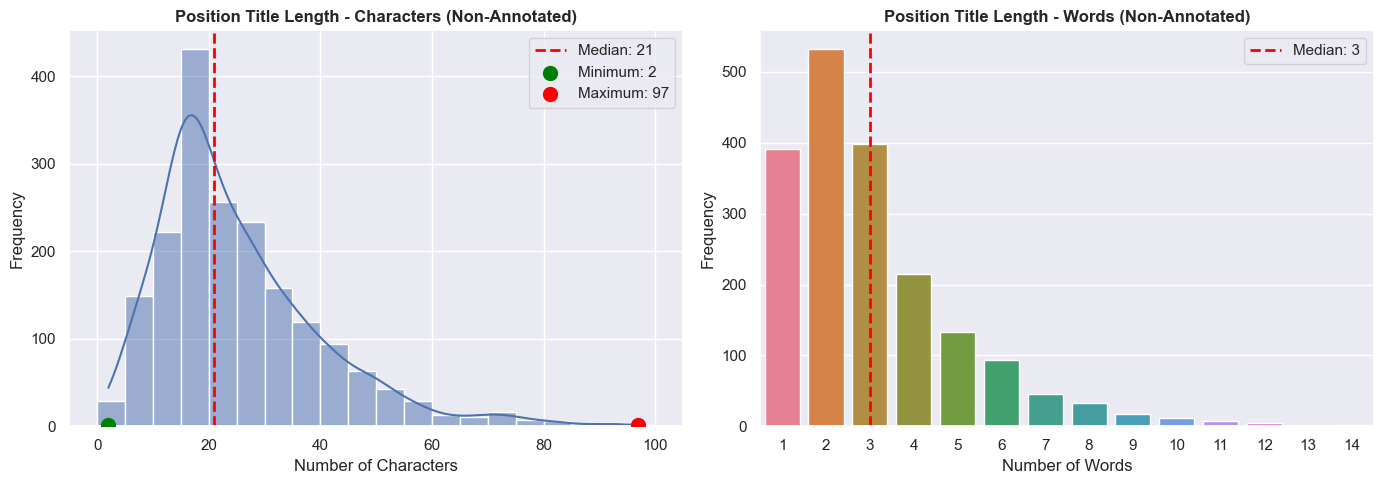

In [50]:
# Visualize title length distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Character length
bins = range(0, int(df_not_annotated['title_length'].max()) + 5, 5)
sns.histplot(df_not_annotated['title_length'], bins=bins, kde=True, ax=axes[0])
axes[0].set_title('Position Title Length - Characters (Non-Annotated)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Number of Characters')
axes[0].set_ylabel('Frequency')
median_chars = df_not_annotated['title_length'].median()
axes[0].axvline(median_chars, color='red', linestyle='--', linewidth=2, label=f"Median: {median_chars:.0f}")

# Add scatter points for minimum and maximum
min_length_not_ann = df_not_annotated['title_length'].min()
y_value_min_not_ann = (df_not_annotated['title_length'] == min_length_not_ann).sum()
axes[0].scatter(min_length_not_ann, y_value_min_not_ann, color='green', s=100, zorder=10, label=f'Minimum: {min_length_not_ann}')

max_length_not_ann = df_not_annotated['title_length'].max()
y_value_max_not_ann = (df_not_annotated['title_length'] == max_length_not_ann).sum()
axes[0].scatter(max_length_not_ann, y_value_max_not_ann, color='red', s=100, zorder=10, label=f'Maximum: {max_length_not_ann}')

axes[0].legend()

# Word count
word_order = sorted(df_not_annotated['title_word_count'].dropna().unique())
sns.countplot(x=df_not_annotated['title_word_count'], ax=axes[1], hue=df_not_annotated['title_word_count'], 
            palette='husl', order=word_order, legend=False)
axes[1].set_title('Position Title Length - Words (Non-Annotated)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Number of Words')
axes[1].set_ylabel('Frequency')
median_words = df_not_annotated['title_word_count'].median()
median_idx = word_order.index(median_words) if median_words in word_order else None
if median_idx is not None:
    axes[1].axvline(median_idx, color='red', linestyle='--', linewidth=2, label=f"Median: {median_words:.0f}")
    axes[1].legend()

plt.tight_layout()
plt.savefig('../reports/figures/title_length_distribution_not_annotated.png', dpi=150)
plt.show()

In [51]:
# Language detection
df_not_annotated['detected_language'] = df_not_annotated['position'].apply(detect_language_simple)

lang_counts_not_ann = df_not_annotated['detected_language'].value_counts()
lang_table_not_ann = pd.DataFrame({
    'Language': lang_counts_not_ann.index,
    'Count': lang_counts_not_ann.values,
    'Percentage (%)': (lang_counts_not_ann / lang_counts_not_ann.sum() * 100).round(2)
})

print("Detected Languages (Non-Annotated):")
display(lang_table_not_ann)

Detected Languages (Non-Annotated):


,Language,Count,Percentage (%)
detected_language,,,
English,English,901,47.77
Other,Other,405,21.47
German,German,294,15.59
French,French,236,12.51
Turkish,Turkish,33,1.75
Spanish,Spanish,17,0.90


In [52]:
# Most common organizations
print("Top 10 Organizations (Non-Annotated):")
org_counts_not_ann = df_not_annotated['organization'].value_counts().head(10)
org_table_not_ann = pd.DataFrame({
    'Organization': org_counts_not_ann.index,
    'Count': org_counts_not_ann.values,
    'Percentage (%)': (org_counts_not_ann / len(df_not_annotated) * 100).round(2)
})
display(org_table_not_ann)

# Most common position titles
print("Top 10 Position Titles (Non-Annotated):")
position_counts_not_ann = df_not_annotated['position'].value_counts().head(10)
position_table_not_ann = pd.DataFrame({
    'Position Title': position_counts_not_ann.index,
    'Count': position_counts_not_ann.values,
    'Percentage (%)': (position_counts_not_ann / len(df_not_annotated) * 100).round(2)
})
display(position_table_not_ann)

Top 10 Organizations (Non-Annotated):


,Organization,Count,Percentage (%)
organization,,,
BMW Group,BMW Group,12,0.64
Daimler AG,Daimler AG,8,0.42
METRO AG,METRO AG,8,0.42
American Express,American Express,7,0.37
BSH Bosch and Siemens Home Appliances Group,BSH Bosch and Siemens Home Appliances Group,7,0.37
Selbstständig,Selbstständig,6,0.32
Kalmar,Kalmar,6,0.32
Scania Group,Scania Group,6,0.32
The Shell Petroleum Development Company of Nigeria Limited,The Shell Petroleum Development Company of Nig...,6,0.32


Top 10 Position Titles (Non-Annotated):


,Position Title,Count,Percentage (%)
position,,,
Geschäftsführer,Geschäftsführer,30,1.59
CEO,CEO,19,1.01
IT Consultant,IT Consultant,16,0.85
Geschäftsführender Gesellschafter,Geschäftsführender Gesellschafter,14,0.74
Consultant,Consultant,13,0.69
Manager,Manager,12,0.64
Managing Director,Managing Director,10,0.53
Project Manager,Project Manager,9,0.48
Partner,Partner,9,0.48


### Key Observations (Non-Annotated Dataset):
- **Similar distribution patterns** to annotated dataset in terms of position counts and title lengths
- **Multilingual data** with same language mix as annotated data
- This dataset will be used for **inference** - predicting department and seniority
- No ground truth labels available for evaluation on this dataset
- Distribution similarity suggests model trained on annotated data should generalize well

## 6. Summary Statistics

In [53]:
# Create summary table
summary = {
    'Metric': [
        'Total CVs (annotated)',
        'Total CVs (unannotated)',
        'Total positions (annotated)',
        'Active positions (our training set)',
        'Avg positions per CV',
        'Unique departments',
        'Unique seniority levels',
        'Department label examples',
        'Seniority label examples',
        'Avg title length (chars)',
        'Avg title length (words)',
    ],
    'Value': [
        len(cvs_annotated),
        len(cvs_not_annotated),
        len(df_annotated),
        len(df_active),
        f"{positions_per_cv.mean():.1f}",
        df_active['department'].nunique(),
        df_active['seniority'].nunique(),
        len(department_labels),
        len(seniority_labels),
        f"{df_active['title_length'].mean():.1f}",
        f"{df_active['title_word_count'].mean():.1f}",
    ]
}

summary_df = pd.DataFrame(summary)
display(summary_df)

,Metric,Value
0,Total CVs (annotated),609
1,Total CVs (unannotated),390
2,Total positions (annotated),2638
3,Active positions (our training set),623
4,Avg positions per CV,4.3
5,Unique departments,11
6,Unique seniority levels,6
7,Department label examples,10145
8,Seniority label examples,9428
9,Avg title length (chars),25.0


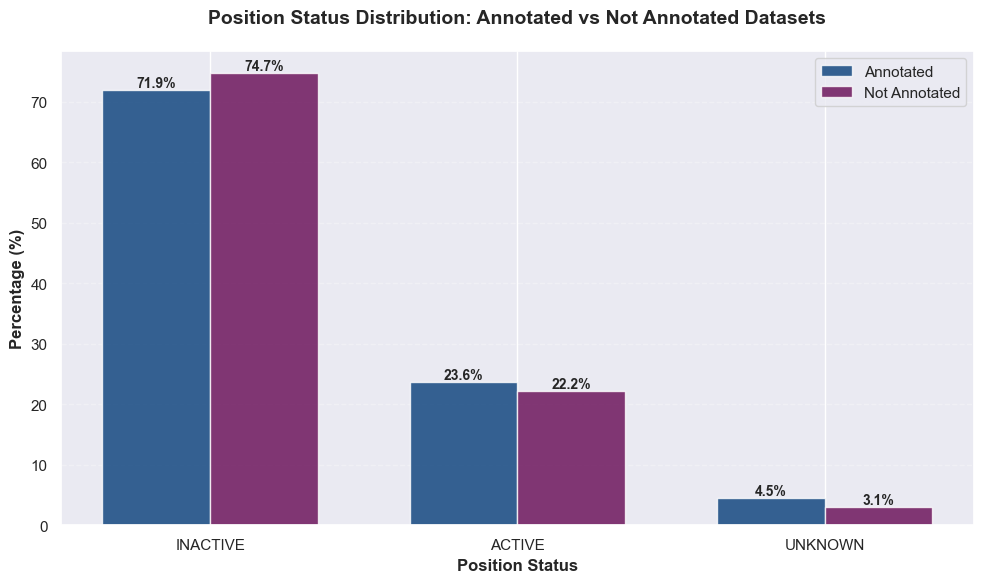

In [54]:
# Comparison of status distribution between annotated and non-annotated datasets

# Prepare data for comparison
status_annotated = df_annotated['status'].value_counts()
status_not_annotated = df_not_annotated['status'].value_counts()

# Create a DataFrame for comparison
comparison_data = pd.DataFrame({
    'Annotated': status_annotated,
    'Not Annotated': status_not_annotated
}).fillna(0)

# Calculate percentages
comparison_pct = comparison_data.div(comparison_data.sum(axis=0), axis=1) * 100

# Create the visualization
fig, ax = plt.subplots(figsize=(10, 6))

# Plot grouped bar chart
x = range(len(comparison_pct.index))
width = 0.35

bars1 = ax.bar([i - width/2 for i in x], comparison_pct['Annotated'], 
            width, label='Annotated', color="#063D79", alpha=0.8)
bars2 = ax.bar([i + width/2 for i in x], comparison_pct['Not Annotated'], 
            width, label='Not Annotated', color='#660954', alpha=0.8)

# Add percentage labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# Customize the plot
ax.set_xlabel('Position Status', fontsize=12, fontweight='bold')
ax.set_ylabel('Percentage (%)', fontsize=12, fontweight='bold')
ax.set_title('Position Status Distribution: Annotated vs Not Annotated Datasets', 
            fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(comparison_pct.index, fontsize=11)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('../reports/figures/status_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

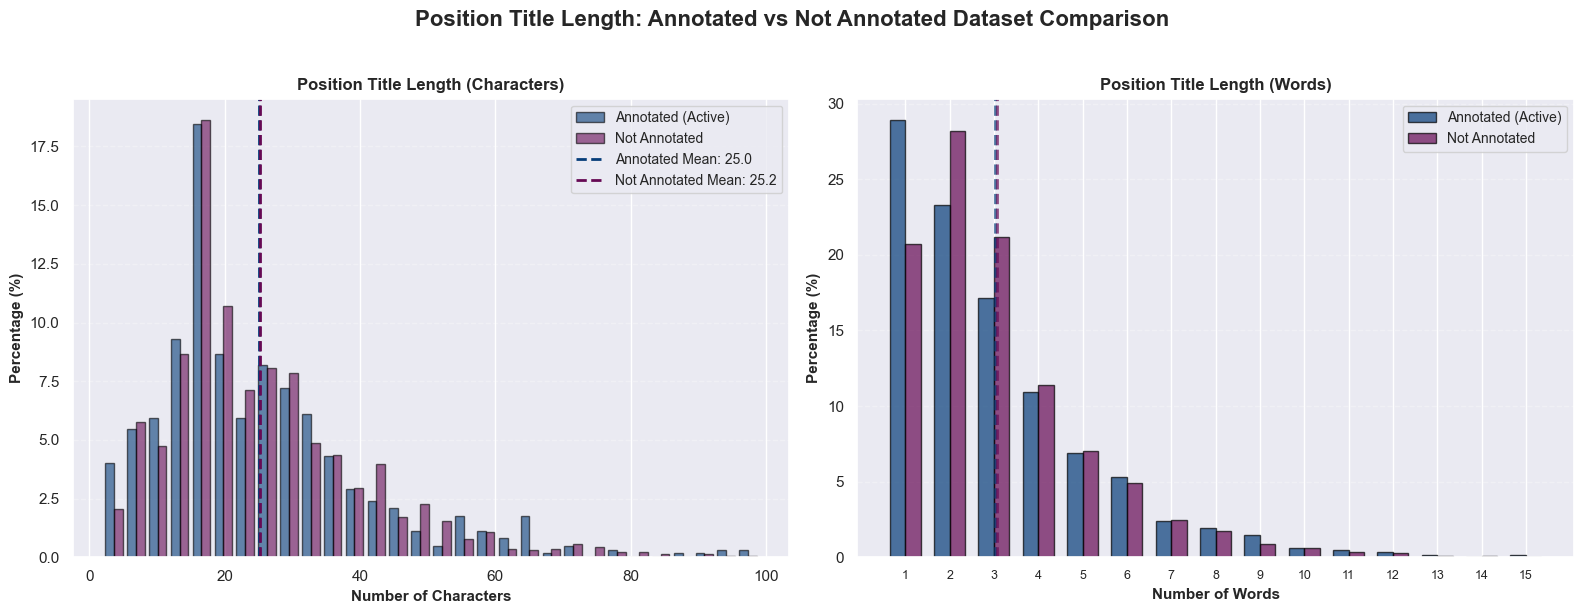

In [55]:
# Title Length Comparison: Annotated vs Not Annotated
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Position Title Length: Annotated vs Not Annotated Dataset Comparison', fontsize=16, fontweight='bold', y=1.02)

# 1. Position Title Length - Characters Comparison (Normalized to Percentage)
title_len_ann = df_active['title_length']
title_len_not_ann = df_not_annotated['title_length']

# Create normalized histograms using weights to convert to percentages
weights_ann = np.ones_like(title_len_ann) / len(title_len_ann) * 100
weights_not_ann = np.ones_like(title_len_not_ann) / len(title_len_not_ann) * 100

axes[0].hist([title_len_ann, title_len_not_ann], bins=30, 
            weights=[weights_ann, weights_not_ann],
            label=['Annotated (Active)', 'Not Annotated'], 
            color=['#063D79', '#660954'], alpha=0.6, edgecolor='black')
axes[0].axvline(title_len_ann.mean(), color='#063D79', linestyle='--', linewidth=2, 
                label=f'Annotated Mean: {title_len_ann.mean():.1f}')
axes[0].axvline(title_len_not_ann.mean(), color='#660954', linestyle='--', linewidth=2,
                label=f'Not Annotated Mean: {title_len_not_ann.mean():.1f}')
axes[0].set_xlabel('Number of Characters', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Percentage (%)', fontsize=11, fontweight='bold')
axes[0].set_title('Position Title Length (Characters)', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(axis='y', alpha=0.3, linestyle='--')

# 2. Position Title Length - Words Comparison (Normalized to Percentage)
title_words_ann = df_active['title_word_count']
title_words_not_ann = df_not_annotated['title_word_count']

# Create side-by-side count plot with percentages
word_range = range(1, max(title_words_ann.max(), title_words_not_ann.max()) + 1)
word_counts_ann = [sum(title_words_ann == w) for w in word_range]
word_counts_not_ann = [sum(title_words_not_ann == w) for w in word_range]

# Convert to percentages
word_pct_ann = [(count / len(title_words_ann) * 100) for count in word_counts_ann]
word_pct_not_ann = [(count / len(title_words_not_ann) * 100) for count in word_counts_not_ann]

x_pos = np.arange(len(word_range))
width = 0.35
bars1 = axes[1].bar(x_pos - width/2, word_pct_ann, width, label='Annotated (Active)', 
                    color='#063D79', alpha=0.7, edgecolor='black')
bars2 = axes[1].bar(x_pos + width/2, word_pct_not_ann, width, label='Not Annotated', 
                    color='#660954', alpha=0.7, edgecolor='black')

axes[1].set_xlabel('Number of Words', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Percentage (%)', fontsize=11, fontweight='bold')
axes[1].set_title('Position Title Length (Words)', fontsize=12, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(word_range, fontsize=9)
axes[1].legend(fontsize=10)
axes[1].grid(axis='y', alpha=0.3, linestyle='--')

# Add mean lines with labels
mean_line1 = axes[1].axvline(title_words_ann.mean() - 1, color='#063D79', linestyle='--', linewidth=2, alpha=0.7,
                label=f'Annotated Mean: {title_words_ann.mean():.2f}')
mean_line2 = axes[1].axvline(title_words_not_ann.mean() - 1, color='#660954', linestyle='--', linewidth=2, alpha=0.7,
                label=f'Not Annotated Mean: {title_words_not_ann.mean():.2f}')


plt.tight_layout()
plt.savefig('../reports/figures/title_length_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

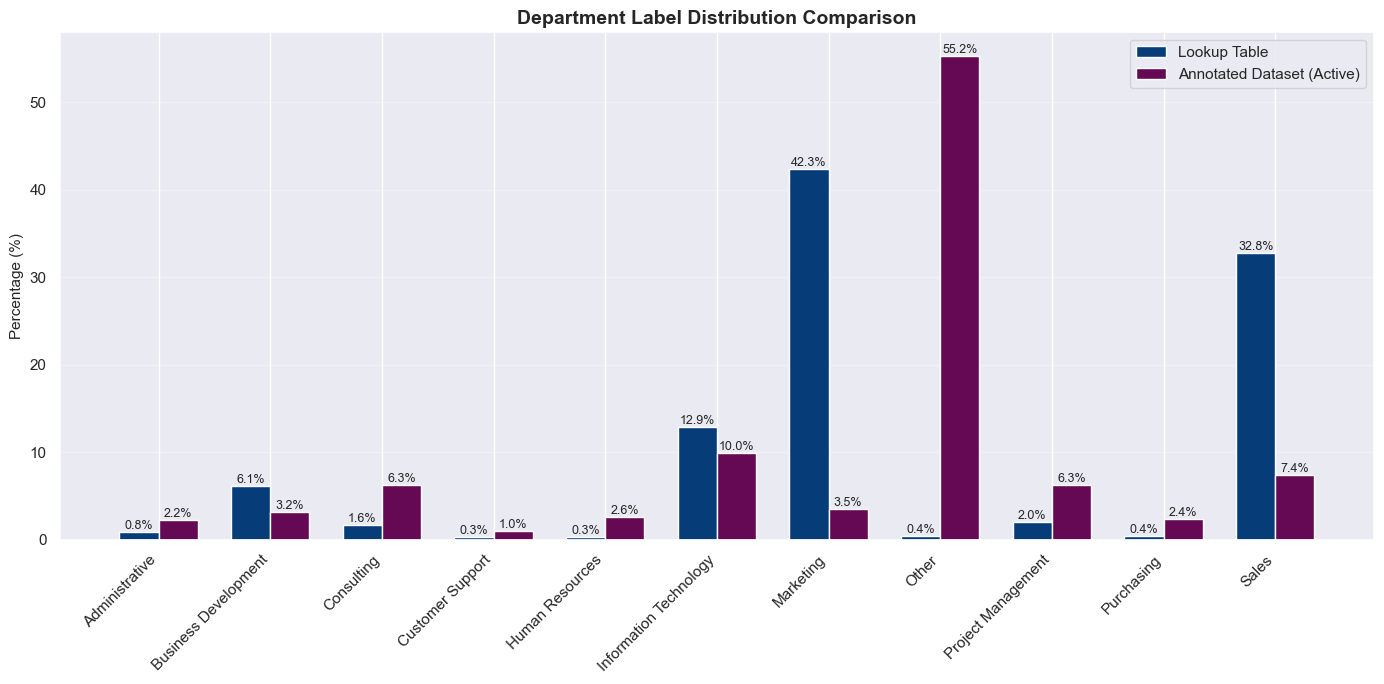

In [56]:
# Compare Department Label Distribution: Lookup Table vs Annotated Dataset
import numpy as np

# Get counts from both sources
dept_lookup_counts = department_labels['label'].value_counts()
dept_annotated_counts = df_active['department'].value_counts()

# Get all unique labels and sort them
all_dept_labels = sorted(set(dept_lookup_counts.index) | set(dept_annotated_counts.index))

# Calculate percentages
lookup_total = dept_lookup_counts.sum()
annotated_total = dept_annotated_counts.sum()

lookup_pct = [(dept_lookup_counts.get(label, 0) / lookup_total * 100) for label in all_dept_labels]
annotated_pct = [(dept_annotated_counts.get(label, 0) / annotated_total * 100) for label in all_dept_labels]

# Create grouped bar chart
fig, ax = plt.subplots(figsize=(14, 7))

x_pos = np.arange(len(all_dept_labels))
bar_width = 0.35

# Create bars with specified colors
bars1 = ax.bar(x_pos - bar_width/2, lookup_pct, bar_width, label='Lookup Table', color='#063D79')
bars2 = ax.bar(x_pos + bar_width/2, annotated_pct, bar_width, label='Annotated Dataset (Active)', color='#660954')

ax.set_xticks(x_pos)
ax.set_xticklabels(all_dept_labels, rotation=45, ha='right')
ax.set_ylabel('Percentage (%)', fontsize=11)
ax.set_title('Department Label Distribution Comparison', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels
for i, (v1, v2) in enumerate(zip(lookup_pct, annotated_pct)):
    if v1 > 0:
        ax.text(i - bar_width/2, v1, f'{v1:.1f}%', ha='center', va='bottom', fontsize=9)
    if v2 > 0:
        ax.text(i + bar_width/2, v2, f'{v2:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('../reports/figures/dept_distribution_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

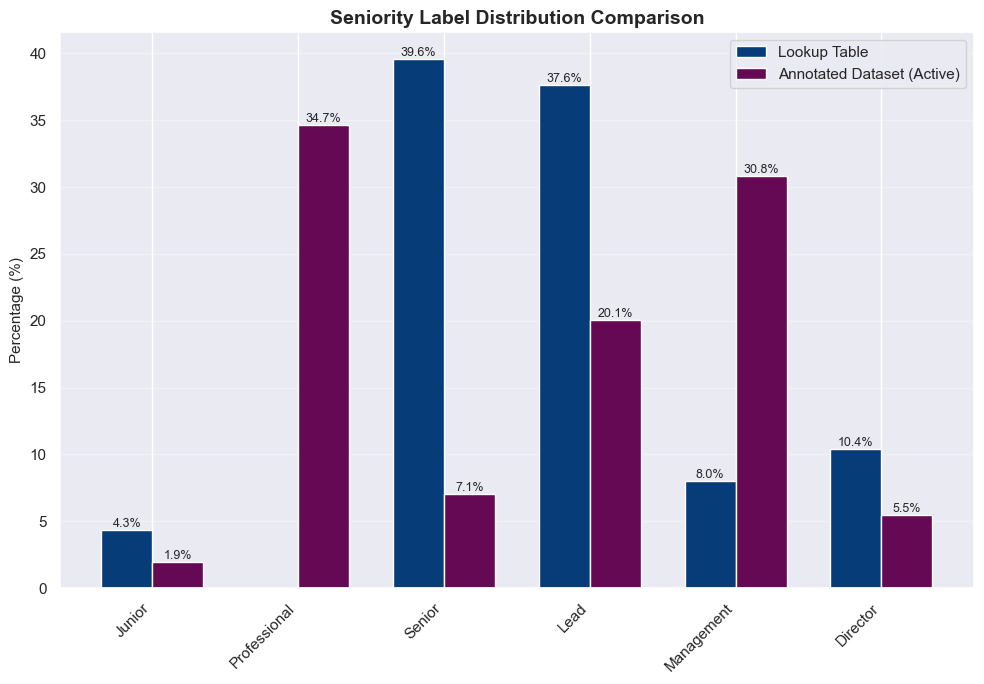

In [57]:
# Compare Seniority Label Distribution: Lookup Table vs Annotated Dataset

# Define custom order
seniority_order = ['Junior', 'Professional', 'Senior', 'Lead', 'Management', 'Director']

# Get counts from both sources
sen_lookup_counts = seniority_labels['label'].value_counts()
sen_annotated_counts = df_active['seniority'].value_counts()

# Calculate percentages
lookup_total = sen_lookup_counts.sum()
annotated_total = sen_annotated_counts.sum()

lookup_pct = [(sen_lookup_counts.get(label, 0) / lookup_total * 100) for label in seniority_order]
annotated_pct = [(sen_annotated_counts.get(label, 0) / annotated_total * 100) for label in seniority_order]

# Create grouped bar chart
fig, ax = plt.subplots(figsize=(10, 7))

x_pos = np.arange(len(seniority_order))
bar_width = 0.35

# Create bars with specified colors
bars1 = ax.bar(x_pos - bar_width/2, lookup_pct, bar_width, label='Lookup Table', color='#063D79')
bars2 = ax.bar(x_pos + bar_width/2, annotated_pct, bar_width, label='Annotated Dataset (Active)', color='#660954')

ax.set_xticks(x_pos)
ax.set_xticklabels(seniority_order, rotation=45, ha='right')
ax.set_ylabel('Percentage (%)', fontsize=11)
ax.set_title('Seniority Label Distribution Comparison', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels
for i, (v1, v2) in enumerate(zip(lookup_pct, annotated_pct)):
    if v1 > 0:
        ax.text(i - bar_width/2, v1, f'{v1:.1f}%', ha='center', va='bottom', fontsize=9)
    if v2 > 0:
        ax.text(i + bar_width/2, v2, f'{v2:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('../reports/figures/seniority_distribution_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

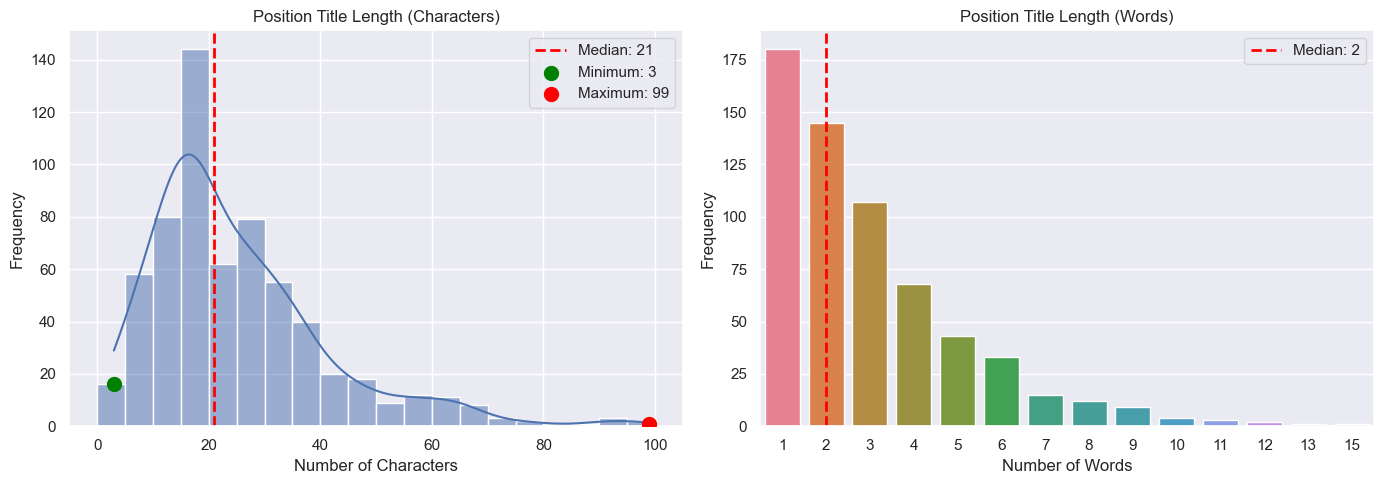

In [58]:
# Visualize title length distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Character length - use bins aligned with integer values
bins = range(0, int(df_active['title_length'].max()) + 5, 5)
sns.histplot(df_active['title_length'], bins=bins, kde=True, ax=axes[0])
axes[0].set_title('Position Title Length (Characters)', fontsize=12)
axes[0].set_xlabel('Number of Characters')
axes[0].set_ylabel('Frequency')
median_chars = df_active['title_length'].median()
axes[0].axvline(median_chars, color='red', linestyle='--', linewidth=2, label=f"Median: {median_chars:.0f}")

# Add scatter points for minimum and maximum
min_length = df_active['title_length'].min()
y_value_min = (df_active['title_length'] == min_length).sum()
axes[0].scatter(min_length, y_value_min, color='green', s=100, zorder=10, label=f'Minimum: {min_length}')

max_length = df_active['title_length'].max()
y_value_max = (df_active['title_length'] == max_length).sum()
axes[0].scatter(max_length, y_value_max, color='red', s=100, zorder=10, label=f'Maximum: {max_length}')

axes[0].legend()

# Word count - use countplot for discrete integer values
word_order = sorted(df_active['title_word_count'].dropna().unique())
sns.countplot(x=df_active['title_word_count'], ax=axes[1], hue=df_active['title_word_count'], palette='husl', order=word_order, legend=False)
axes[1].set_title('Position Title Length (Words)', fontsize=12)
axes[1].set_xlabel('Number of Words')
axes[1].set_ylabel('Frequency')
# For countplot, axvline uses bar index (0, 1, 2...), not the actual x-value
median_words = df_active['title_word_count'].median()
median_idx = word_order.index(median_words) if median_words in word_order else None
if median_idx is not None:
    axes[1].axvline(median_idx, color='red', linestyle='--', linewidth=2, label=f"Median: {median_words:.0f}")
    axes[1].legend()

plt.tight_layout()
plt.savefig('../reports/figures/title_length_distribution.png', dpi=150)
plt.show()

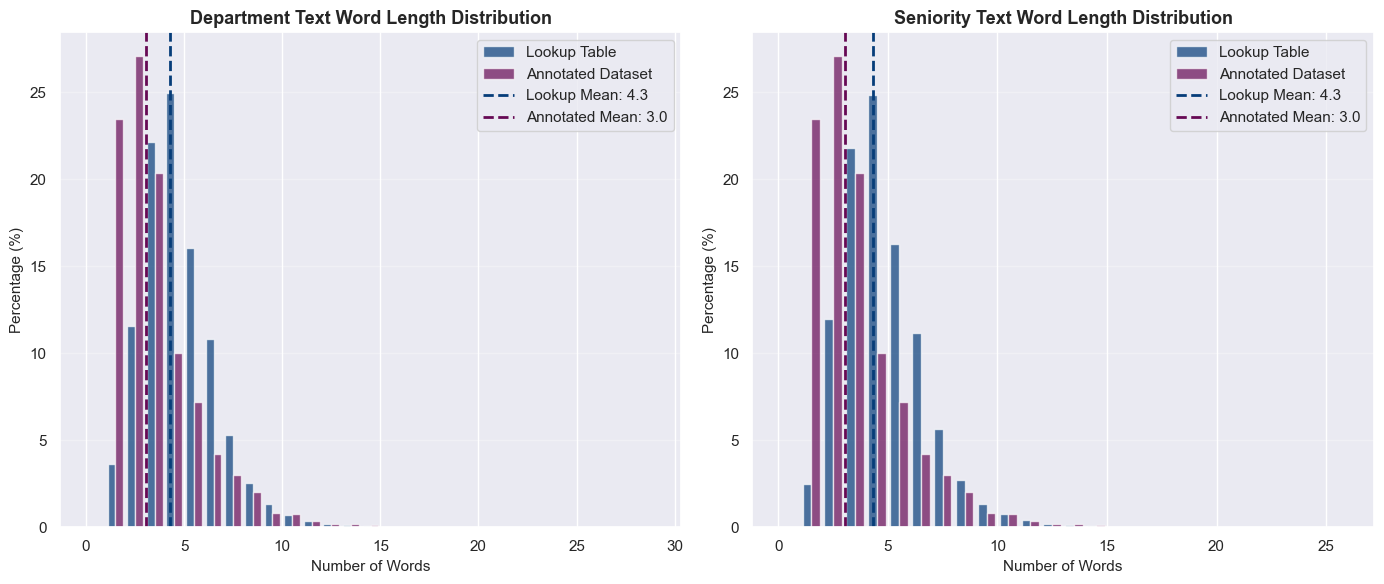

In [59]:
# Compare word length distribution: Department and Seniority text descriptions
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Department text word length comparison
dept_lookup_word_lengths = department_labels['text'].apply(lambda x: len(str(x).split()))
dept_annotated_word_lengths = df_annotated['position'].apply(lambda x: len(str(x).split()))

# Create normalized histogram for department (percentage)
bins_dept = range(0, max(dept_lookup_word_lengths.max(), dept_annotated_word_lengths.max()) + 2)
weights_lookup_dept = np.ones_like(dept_lookup_word_lengths) / len(dept_lookup_word_lengths) * 100
weights_annotated_dept = np.ones_like(dept_annotated_word_lengths) / len(dept_annotated_word_lengths) * 100

axes[0].hist([dept_lookup_word_lengths, dept_annotated_word_lengths], bins=bins_dept, 
            weights=[weights_lookup_dept, weights_annotated_dept],
            color=['#063D79', '#660954'], alpha=0.7, label=['Lookup Table', 'Annotated Dataset'])
axes[0].set_xlabel('Number of Words', fontsize=11)
axes[0].set_ylabel('Percentage (%)', fontsize=11)
axes[0].set_title('Department Text Word Length Distribution', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Add mean lines
mean_lookup_dept = dept_lookup_word_lengths.mean()
mean_annotated_dept = dept_annotated_word_lengths.mean()
axes[0].axvline(mean_lookup_dept, color='#063D79', linestyle='--', linewidth=2, 
               label=f'Lookup Mean: {mean_lookup_dept:.1f}')
axes[0].axvline(mean_annotated_dept, color='#660954', linestyle='--', linewidth=2,
               label=f'Annotated Mean: {mean_annotated_dept:.1f}')
axes[0].legend()

# Seniority text word length comparison
sen_lookup_word_lengths = seniority_labels['text'].apply(lambda x: len(str(x).split()))
sen_annotated_word_lengths = df_annotated['position'].apply(lambda x: len(str(x).split()))

# Create normalized histogram for seniority (percentage)
bins_sen = range(0, max(sen_lookup_word_lengths.max(), sen_annotated_word_lengths.max()) + 2)
weights_lookup_sen = np.ones_like(sen_lookup_word_lengths) / len(sen_lookup_word_lengths) * 100
weights_annotated_sen = np.ones_like(sen_annotated_word_lengths) / len(sen_annotated_word_lengths) * 100

axes[1].hist([sen_lookup_word_lengths, sen_annotated_word_lengths], bins=bins_sen,
            weights=[weights_lookup_sen, weights_annotated_sen],
            color=['#063D79', '#660954'], alpha=0.7, label=['Lookup Table', 'Annotated Dataset'])
axes[1].set_xlabel('Number of Words', fontsize=11)
axes[1].set_ylabel('Percentage (%)', fontsize=11)
axes[1].set_title('Seniority Text Word Length Distribution', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

# Add mean lines
mean_lookup_sen = sen_lookup_word_lengths.mean()
mean_annotated_sen = sen_annotated_word_lengths.mean()
axes[1].axvline(mean_lookup_sen, color='#063D79', linestyle='--', linewidth=2,
               label=f'Lookup Mean: {mean_lookup_sen:.1f}')
axes[1].axvline(mean_annotated_sen, color='#660954', linestyle='--', linewidth=2,
               label=f'Annotated Mean: {mean_annotated_sen:.1f}')
axes[1].legend()

plt.tight_layout()
plt.savefig('../reports/figures/word_length_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Key Findings & Implications for Modeling

**Data Characteristics:**
- **Multilingual data**: Position titles in English, German, French, Spanish
- **Class imbalance**: "Other" dominates departments in annotated dataset
- **Short text**: Most titles are 2-5 words
- **Multiple active positions**: Some people have multiple current jobs

**Departments:**
- All department labels from the annotated dataset are present in `department-v2.csv`
- Both datasets contain 11 unique department labels
- Complete coverage for rule-based matching

**Seniority:**
- **Critical finding**: The seniority lookup table (`seniority-v2.csv`) contains only **5 unique labels** (Director, Junior, Lead, Management, Senior)
- The annotated evaluation dataset contains **6 unique labels** - including **"Professional"**
- **"Professional" is completely missing** from the training CSV and represents **~35%** of the evaluation data
- **Incomplete coverage**: Rule-based classifier cannot match "Professional" directly
- **Impact on baseline**: This limitation will reduce overall accuracy and make the rule-based baseline less effective as a comparison point for ML models

### Next Steps:
1. Implement baseline rule-based classifier using exact matching
2. Test embedding similarity with label descriptions
3. Train TF-IDF + LogReg as supervised baseline
4. Compare approaches on held-out test set